#Tematica:
Ligas de fútbol de Europa

#Integrantes:
* Lucas Venencia
* Manolo Bengochea

#Presentacion

El fútbol en sí es un deporte no muy predecible: es fácil encontrar partidos en los que un club denominado 'chico' (club con menor poder adquisitivo que la mayoria) le gana a un 'grande' (club con mayor poder adquisitivo que la mayoria y muchas copas ganadas).

Sin embargo, por algo siempre se habla de las buenas y malas rachas, inversiones cuestionables, diferencias entre los equipos, fichajes sobrevalorados... ¿será posible determinar con anticipación cuándo ocurrirá un fenómeno de este estilo?

#Objetivos generales
El proyecto estará centrado en entender la influencia del poder económico que manejan los clubes de las 5 ligas europeas analizadas. Para ello proponemos varias preguntas a responder:

* ¿Qué tienen en común los equipos que descienden? ¿Descienden sólo los que ascendieron a principio de la temporada? ¿Descienden los equipos mas goleados o los equipos que meten menos goles?
* En las ligas donde sale campeón un equipo varias veces seguidas, ¿qué tienen en común los inicios de esas temporadas?
* ¿Siempre que un equipo gasta más de lo que recupera, obtiene mejores resultados? ¿Qué tan común es que un equipo con mediano o bajo valor de mercado clasifique a la Champions League?

Básicamente se busca conocer si las principales ligas europeas poseen comportamientos similares y cuales son diferentes, y si es posible predecir a partir de algunos indicadores, resultados y posiciones finales de los equipos, estableciendo las diferencias existentes entre las ligas europeas. Por ejemplo, quizás tener determinados valores en ciertos campos implicarían estar entre los primeros 2 en tal liga pero en el sexto/septimo lugar en otra.

# Fuente del dataset



Elegimos dos datasets para trabajar:
* Uno proviene de Understat (una página web de predicciones/especulaciones sobre las posiciones y goles de los equipos) y contiene todas las tablas de posiciones, estadisticas, especulaciones de las ligas de Francia, Alemania, España, Italia, Inglaterra, y Rusia, de los años 2014 al 2019;
* El otro, proveniente de Transfermarket (una pagina que lleva todos los números de los equipos con respecto a su valor de plantilla y dinero invertido y obtenido en traspasos de jugadores cada temporada)

Posiciones, partidos y especulaciones: 
* https://www.kaggle.com/datasets/slehkyi/extended-football-stats-for-european-leagues-xg?resource=download

Fichajes:
* https://ericmordonez.com/blog/european-soccer-transfers-data-set/

#Preparacion (EDA)

En esta seccion importamos librerias, cargamos los datos y les hacemos algunas modificaciones como cambios en los nombres de columnas, creacion de nuevas variables, concatenacion de dataframes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import glob

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb 
from sklearn.linear_model import LinearRegression as LR
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
##Manolo
stats_0 = pd.read_csv('/content/drive/MyDrive/data_science/final_project/understat.com.csv')
stats_per_game0 = pd.read_csv('/content/drive/MyDrive/data_science/final_project/understat_per_game.csv')

In [ ]:
##Lucas
stats_0 = pd.read_excel('/content/drive/MyDrive/Cursos extra - Programación/Coderhouse/Data Science/PROYECTO FINAL/understat.com.xlsx')
stats_per_game0 = pd.read_excel('/content/drive/MyDrive/Cursos extra - Programación/Coderhouse/Data Science/PROYECTO FINAL/understat_per_game.xlsx')

In [ ]:
stats_0.head(3)

In [ ]:
stats_per_game0.head(3)

,league,year,h_a,xG,xGA,npxG,npxGA,deep,deep_allowed,scored,...,ppda_coef,ppda_att,ppda_def,oppda_coef,oppda_att,oppda_def,team,xG_diff,xGA_diff,xpts_diff
0,Bundesliga,2014,h,2.57012,1.198420,2.57012,1.198420,5,4,2,...,9.625000,231,24,21.850000,437,20,Bayern Munich,0.57012,0.198420,-0.6514
1,Bundesliga,2014,a,1.50328,1.307950,1.50328,1.307950,10,1,1,...,4.756098,195,41,17.695652,407,23,Bayern Munich,0.50328,0.307950,0.5143
2,Bundesliga,2014,h,1.22987,0.310166,1.22987,0.310166,13,3,2,...,5.060606,167,33,16.961538,441,26,Bayern Munich,-0.77013,0.310166,-0.8412


In [5]:
stats = stats_0.rename(columns={"Tournament":"league", "Year":"year"})
stats_per_game = stats_per_game0.replace(to_replace = ["h","a"], value = ["local","visitante"])

In [6]:
stats = stats_0.rename(columns={"Unnamed: 0":"league", "Unnamed: 1":"year"})
stats_per_game = stats_per_game0.replace(to_replace = ["h","a"], value = ["local","visitante"])

In [ ]:
stats.shape

In [ ]:
stats_per_game.shape

In [ ]:
stats.dtypes

In [ ]:
stats_per_game.dtypes

In [ ]:
stats.count()

In [ ]:
stats_per_game.count()

No se observan valores nulos

In [ ]:
stats.describe().T

In [ ]:
stats_per_game.describe().T

Aqui definimos una funcion que coloque a cada equipo de cada temporada en tres categorias en funcion de su posicion en la tabla general en la temporada analizada: Top 5, Mitad y Fondo

In [15]:
def top4 (t):
  if t['position'] <= 4:
    return 'Top 4'
  if t['position'] < 15:
    return 'Mitad'
  else:
    return 'Fondo'

In [16]:
stats['Tabla1'] = stats['position']
stats['Tabla1'] = stats.apply (lambda t: top4(t), axis =1)

In [17]:
def fondo_resto (t):
  if t['position'] > 15:
    return 'fondo'
  else:
    return 'resto'

In [18]:
stats['Tabla2'] = stats['position']
stats['Tabla2'] = stats.apply (lambda t: fondo_resto(t), axis =1)

Se crearon varias variables para facilitar el trabajo

In [19]:
promedio_de_puntos = stats.pts / stats.matches
promedio_de_goles = stats.scored / stats.matches
promedio_de_goles_concedidos = stats.missed / stats.matches
diferencia_de_puntos = stats.xpts - stats.pts

# Datos de fichajes agregados
Finalmente pudimos incorporar data relacionada al mercado de fichajes a nuestro repertorio de datos, esto era algo wue nos quedaba pendiente ya que no podiamos realizar predicciones útiles sin datos de pre-temporada (como los fichajes).

Debido a la falta de correlacion entre las diferentes tablas, tuvimos que hacer muchos cambios de valores manualmente, como los nombres de los equipos.

Data: https://drive.google.com/drive/folders/1oUSJZ8NKquFn7UzmadSaNYaRrTOG4GMx?usp=sharing

In [20]:
stats['year'].value_counts()

2014    114
2015    114
2016    114
2017    114
2018    114
2019    114
Name: year, dtype: int64

In [21]:
def leer_ins(path):
    filenames = glob.glob(path + "/*.csv")
    dataframes = {}
    for file in filenames:
        dataframes[file.split('/')[-1].replace('.csv', '')] = pd.read_csv(file)
    
    return dataframes

In [22]:
#manolo
path = '/content/drive/MyDrive/futbol project/fichajes'
dataframes = leer_ins(path)

In [ ]:
#lucas
path = '/content/drive/MyDrive/Cursos extra - Programación/Coderhouse/Data Science/PROYECTO FINAL/fichajes'
dataframes = leer_ins(path)

In [ ]:
dataframes

In [24]:
fichajes_0 = pd.concat(dataframes.values(), ignore_index=True)
fichajes = fichajes_0.rename(columns={"season":"year", "club":"team"})
fichajes.head(5)

,team,name,age,nationality,position,short_pos,market_value,dealing_club,dealing_country,fee,movement,window,league,year,is_loan,loan_status
0,AS Monaco,Aymen Abdennour,24.0,Tunisia,Centre-Back,CB,6000000.0,Toulouse,France,13000000.0,in,summer,Ligue 1,2014,False,NaN
1,AS Monaco,Tiemoué Bakayoko,19.0,France,Defensive Midfield,DM,1250000.0,Stade Rennais,France,8000000.0,in,summer,Ligue 1,2014,False,NaN
2,AS Monaco,Paul Nardi,20.0,France,Goalkeeper,GK,500000.0,AS Nancy,France,3000000.0,in,summer,Ligue 1,2014,False,NaN
3,AS Monaco,Bernardo Silva,19.0,Portugal,Attacking Midfield,AM,2500000.0,Benfica,Portugal,0.0,in,summer,Ligue 1,2014,True,free loan
4,AS Monaco,Maarten Stekelenburg,31.0,Netherlands,Goalkeeper,GK,5000000.0,Fulham,England,0.0,in,summer,Ligue 1,2014,True,free loan


In [25]:
stats['team_year'] = stats['team'] + ' ' + (stats['year']).astype(str)
stats.head(21)

,league,year,position,team,matches,wins,draws,loses,scored,missed,...,npxGD,ppda_coef,oppda_coef,deep,deep_allowed,xpts,xpts_diff,Tabla1,Tabla2,team_year
0,La_liga,2014,1,Barcelona,38,30,4,4,110,21,...,73.049305,5.683535,16.367593,489,114,94.0813,0.0813,Top 4,resto,Barcelona 2014
1,La_liga,2014,2,Real Madrid,38,30,2,6,118,38,...,47.213090,10.209085,12.929510,351,153,81.7489,-10.2511,Top 4,resto,Real Madrid 2014
2,La_liga,2014,3,Atletico Madrid,38,23,9,6,67,29,...,25.748737,8.982028,9.237091,197,123,73.1353,-4.8647,Top 4,resto,Atletico Madrid 2014
3,La_liga,2014,4,Valencia,38,22,11,5,70,32,...,16.257501,8.709827,7.870225,203,172,63.7068,-13.2932,Top 4,resto,Valencia 2014
4,La_liga,2014,5,Sevilla,38,23,7,8,71,45,...,20.178070,8.276148,9.477805,305,168,67.3867,-8.6133,Mitad,resto,Sevilla 2014
5,La_liga,2014,6,Villarreal,38,16,12,10,48,37,...,16.809461,10.072085,8.679660,242,171,62.7363,2.7363,Mitad,resto,Villarreal 2014
6,La_liga,2014,7,Athletic Club,38,15,10,13,42,41,...,0.088990,7.462406,9.403965,183,171,53.3585,-1.6415,Mitad,resto,Athletic Club 2014
7,La_liga,2014,8,Celta Vigo,38,13,12,13,47,44,...,7.853459,6.056173,10.882769,287,207,55.0488,4.0488,Mitad,resto,Celta Vigo 2014
8,La_liga,2014,9,Malaga,38,14,8,16,42,48,...,-8.637099,7.792069,7.019068,184,184,48.5128,-1.4872,Mitad,resto,Malaga 2014
9,La_liga,2014,10,Rayo Vallecano,38,15,4,19,46,68,...,-20.412932,6.157978,9.735109,147,219,43.5455,-5.4545,Mitad,resto,Rayo Vallecano 2014


Francia

In [26]:
fichajes_fr = fichajes[fichajes['league'] == 'Ligue 1']

In [27]:
stats_fr = stats[stats['league'] == 'Ligue_1']

In [ ]:
stats_fr['team'].value_counts()

In [ ]:
fichajes_fr['team'].value_counts()

In [30]:
fichajes = fichajes.replace(to_replace = ["Paris Saint-Germain","LOSC Lille","Olympique Lyon","FC Nantes","OGC Nice","Montpellier HSC","Stade Rennais FC","FC Girondins Bordeaux",
                            "AS Saint-Étienne","Olympique Marseille","AS Monaco","FC Toulouse","EA Guingamp","SM Caen","SCO Angers","FC Metz","Dijon FCO","Stade Reims","FC Lorient",
                            "Amiens SC","RC Strasbourg Alsace","ES Troyes AC","Nîmes Olympique","FC Évian Thonon Gaillard","RC Lens","AS Nancy-Lorraine","Stade Brest 29"], 
                            value = ["Paris Saint Germain","Lille","Lyon","Nantes","Nice","Montpellier","Rennes","Bordeaux",
                            "Saint-Etienne","Marseille","Monaco","Toulouse","Guingamp","Caen","Angers","Metz","Dijon","Reims","Lorient",
                            "Amiens","Strasbourg", "Troyes","Nimes","Evian Thonon Gaillard","Lens","Nancy","Brest"])

Alemania

In [31]:
fichajes_fr = fichajes[fichajes['league'] == '1 Bundesliga']

In [32]:
stats_fr = stats[stats['league'] == 'Bundesliga']

In [ ]:
stats_fr['team'].value_counts()

In [ ]:
fichajes_fr['team'].value_counts()

In [35]:
fichajes = fichajes.replace(to_replace = ["TSG 1899 Hoffenheim","SV Werder Bremen","1.FSV Mainz 05","FC Schalke 04","VfL Wolfsburg","FC Augsburg",
                                          "Bayer 04 Leverkusen","SC Freiburg","Hertha BSC","VfB Stuttgart","1. FC Köln","Borussia Mönchengladbach",
                                          "Bayern Munich","RB Leipzig","SV Darmstadt 98","Fortuna Düsseldorf","SC Paderborn 07","FC Ingolstadt 04",
                                          "1.FC Union Berlin","1.FC Nuremberg"], 
                            value = ["Hoffenheim","Werder Bremen","Mainz 05","Schalke 04","Wolfsburg","Augsburg","Bayer Leverkusen","Freiburg",
                                     "Hertha Berlin","VfB Stuttgart","FC Cologne","Borussia M.Gladbach","Bayern Munich","RasenBallsport Leipzig",
                                     "Darmstadt","Fortuna Duesseldorf","Paderborn","Ingolstadt","Union Berlin","Nuernberg"])

España

In [36]:
fichajes_fr = fichajes[fichajes['league'] == 'Laliga']

In [37]:
stats_fr = stats[stats['league'] == 'La_liga']

In [ ]:
stats_fr['team'].value_counts()

In [ ]:
fichajes_fr['team'].value_counts()

In [40]:
fichajes = fichajes.replace(to_replace = ["Granada CF","Sevilla FC","SD Eibar","Valencia CF","CD Leganés","Atlético Madrid","Villarreal CF","Getafe CF","Deportivo Alavés",
                                          "RCD Espanyol Barcelona","Real Betis Balompié","Levante UD","Deportivo de La Coruña","Celta de Vigo","Málaga CF",
                                          "FC Barcelona","Rayo Vallecano","UD Las Palmas","Athletic Bilbao","Real Valladolid CF","CA Osasuna","Girona FC",
                                          "RCD Mallorca","Sporting Gijón","Córdoba CF ","Elche CF","UD Almería"], 
                            value = ["Granada","Sevilla","Eibar","Valencia","Leganes","Atletico Madrid","Villarreal","Getafe","Alaves","Espanyol","Real Betis","Levante",
                                     "Deportivo La Coruna","Celta Vigo","Malaga","Barcelona","Rayo Vallecano","Las Palmas","Athletic Club","Real Valladolid",
                                     "Osasuna","Girona","Mallorca","Sporting Gijon","Cordoba","Elche","Almeria"])

Inglaterra

In [41]:
fichajes_fr = fichajes[fichajes['league'] == 'Premier League']

In [42]:
stats_fr = stats[stats['league'] == 'EPL']

In [ ]:
stats_fr['team'].value_counts()

In [ ]:
fichajes_fr['team'].value_counts()

In [45]:
fichajes = fichajes.replace(to_replace = ["Chelsea FC","Watford FC","Leicester City","Everton FC","Liverpool FC","Southampton FC","AFC Bournemouth",
                                          "Swansea City","Arsenal FC","Burnley FC","Sunderland AFC","Tottenham Hotspur","Brighton & Hove Albion",
                                          "Stoke City","Norwich City","Hull City","Huddersfield Town","Middlesbrough FC","Cardiff City","Fulham FC"], 
                            value = ["Chelsea","Watford","Leicester","Everton","Liverpool","Southampton","Bournemouth","Swansea","Arsenal",
                                     "Burnley","Sunderland","Tottenham","Brighton","Stoke","Norwich","Hull","Huddersfield","Middlesbrough",
                                     "Cardiff","Fulham"])

Italia

In [46]:
fichajes_fr = fichajes[fichajes['league'] == 'Serie A']

In [47]:
stats_fr = stats[stats['league'] == 'Serie_A']

In [ ]:
stats_fr['team'].value_counts()

In [ ]:
fichajes_fr['team'].value_counts()

In [50]:
fichajes = fichajes.replace(to_replace = ["Atalanta BC","Genoa CFC","Juventus FC","Inter Milan","UC Sampdoria","Chievo Verona","AS Roma","Udinese Calcio",
                                          "ACF Fiorentina","Torino FC","Hellas Verona","SSC Napoli","Bologna FC 1909","US Sassuolo","SS Lazio","Parma FC",
                                          "Cagliari Calcio","FC Empoli","US Palermo","SPAL","FC Crotone","Delfino Pescara 1936","AC Cesena","Frosinone Calcio",
                                          "Carpi FC 1909","Benevento Calcio","US Lecce","Brescia Calcio"], 
                            value = ["Atalanta","Genoa","Juventus FC","Inter","Sampdoria","Chievo","Roma","Udinese","Fiorentina","Torino","Verona",
                                     "Napoli","Bologna","Sassuolo","Lazio","Parma","Cagliari","Empoli","Palermo","SPAL 2013","Crotone","Pescara",
                                     "Cesena","Frosinone","Carpi","Benevento","Lecce","Brescia"])

In [51]:
fichajes['team_year'] = fichajes['team'] + ' ' + (fichajes['year']).astype(str)
fichajes.head()

,team,name,age,nationality,position,short_pos,market_value,dealing_club,dealing_country,fee,movement,window,league,year,is_loan,loan_status,team_year
0,Monaco,Aymen Abdennour,24.0,Tunisia,Centre-Back,CB,6000000.0,Toulouse,France,13000000.0,in,summer,Ligue 1,2014,False,NaN,Monaco 2014
1,Monaco,Tiemoué Bakayoko,19.0,France,Defensive Midfield,DM,1250000.0,Stade Rennais,France,8000000.0,in,summer,Ligue 1,2014,False,NaN,Monaco 2014
2,Monaco,Paul Nardi,20.0,France,Goalkeeper,GK,500000.0,AS Nancy,France,3000000.0,in,summer,Ligue 1,2014,False,NaN,Monaco 2014
3,Monaco,Bernardo Silva,19.0,Portugal,Attacking Midfield,AM,2500000.0,Benfica,Portugal,0.0,in,summer,Ligue 1,2014,True,free loan,Monaco 2014
4,Monaco,Maarten Stekelenburg,31.0,Netherlands,Goalkeeper,GK,5000000.0,Fulham,England,0.0,in,summer,Ligue 1,2014,True,free loan,Monaco 2014


In [52]:
fichajes_in_all = fichajes[fichajes['movement'] == 'in']
fichajes_in = fichajes_in_all[fichajes_in_all['window'] == 'summer']

In [53]:
stats['team'].value_counts()

Barcelona                6
Bayern Munich            6
Sassuolo                 6
AC Milan                 6
Torino                   6
                        ..
Elche                    1
Evian Thonon Gaillard    1
Lens                     1
GFC Ajaccio              1
FC Tambov                1
Name: team, Length: 168, dtype: int64

In [54]:
fichajes_in['team'].value_counts()

Genoa                    106
Sampdoria                 88
Roma                      85
Verona                    77
Eibar                     77
                        ... 
Athletic Club              9
Almeria                    9
Evian Thonon Gaillard      9
GFC Ajaccio                8
Cardiff                    6
Name: team, Length: 142, dtype: int64

In [55]:
fichajes_in_defensas = fichajes_in[fichajes_in['short_pos'] == 'CB']
fichajes_in_defensas = fichajes_in_defensas.rename(columns = {"market_value":"value_of_new_def"})

fichajes_in_rw = fichajes_in[fichajes_in['short_pos'] == 'RW']
fichajes_in_rw = fichajes_in_rw.rename(columns = {"market_value":"value_of_new_att"})
fichajes_in_lw = fichajes_in[fichajes_in['short_pos'] == 'LW']
fichajes_in_lw = fichajes_in_lw.rename(columns = {"market_value":"value_of_new_att"})
fichajes_in_ss = fichajes_in[fichajes_in['short_pos'] == 'SS']
fichajes_in_ss = fichajes_in_ss.rename(columns = {"market_value":"value_of_new_att"})

fichajes_in_attack_list = [fichajes_in_rw, fichajes_in_lw, fichajes_in_ss]
fichajes_in_attack = pd.concat(fichajes_in_attack_list)

In [56]:
aux0 = fichajes_in.groupby(['team_year'])['market_value'].sum()
aux1 = fichajes_in.groupby(['team_year'])['age'].mean()
aux2 = fichajes_in_defensas.groupby(['team_year'])['short_pos'].count()
aux3 = fichajes_in_defensas.groupby(['team_year'])['value_of_new_def'].sum()
aux4 = fichajes_in_attack.groupby(['team_year'])['short_pos'].count()
aux5 = fichajes_in_attack.groupby(['team_year'])['value_of_new_att'].sum()
aux6 = stats.groupby(['team'])['position'].mean()

aux10 = pd.DataFrame(data = aux0)
aux11 = pd.DataFrame(data = aux1)
aux12 = pd.DataFrame(data = aux2)
aux13 = pd.DataFrame(data = aux3)
aux14 = pd.DataFrame(data = aux4)
aux15 = pd.DataFrame(data = aux5)
aux16 = pd.DataFrame(data = aux6)

In [57]:
result1 = pd.merge(stats, aux10, on="team_year")
result2 = pd.merge(result1, aux11, on="team_year")
result3 = pd.merge(result2, aux12, on="team_year")
result4 = pd.merge(result3, aux13, on="team_year")
result5 = pd.merge(result4, aux14, on="team_year")
result6 = pd.merge(result5, aux15, on="team_year")
result7 = pd.merge(result6, aux16, on="team")
result = result7.rename(columns={"market_value":"value_added_to_team", "age":"avg_age_of_new_players", "short_pos_x":"amount_new_defenders", "short_pos_y":"amount_new_attackers",
                                 "position_y":"avg_position"})

In [58]:
result

,league,year,position_x,team,matches,wins,draws,loses,scored,missed,...,Tabla1,Tabla2,team_year,value_added_to_team,avg_age_of_new_players,amount_new_defenders,value_of_new_def,amount_new_attackers,value_of_new_att,avg_position
0,La_liga,2014,3,Atletico Madrid,38,23,9,6,67,29,...,Top 4,resto,Atletico Madrid 2014,111500000.0,24.909091,1,1500000.0,2,48000000.0,2.833333
1,La_liga,2015,3,Atletico Madrid,38,28,4,6,63,18,...,Top 4,resto,Atletico Madrid 2015,105000000.0,23.000000,1,15000000.0,1,9000000.0,2.833333
2,La_liga,2018,2,Atletico Madrid,38,22,10,6,55,29,...,Top 4,resto,Atletico Madrid 2018,174000000.0,24.500000,1,0.0,1,35000000.0,2.833333
3,La_liga,2019,4,Atletico Madrid,38,18,16,4,51,27,...,Top 4,resto,Atletico Madrid 2019,197900000.0,24.444444,2,45000000.0,1,70000000.0,2.833333
4,La_liga,2014,5,Sevilla,38,23,7,8,71,45,...,Mitad,resto,Sevilla 2014,68200000.0,25.153846,4,14000000.0,1,12000000.0,5.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,Ligue_1,2019,6,Reims,28,10,11,7,26,21,...,Mitad,resto,Reims 2019,19250000.0,21.500000,2,9000000.0,1,1750000.0,11.750000
340,Ligue_1,2018,9,Nimes,38,15,8,15,57,58,...,Mitad,resto,Nimes 2018,12900000.0,25.000000,2,350000.0,1,1750000.0,13.500000
341,Ligue_1,2019,18,Nimes,28,7,6,15,29,44,...,Fondo,fondo,Nimes 2019,13400000.0,26.000000,1,3500000.0,1,1000000.0,13.500000
342,Ligue_1,2019,1,Paris Saint Germain,27,22,2,3,75,24,...,Top 4,resto,Paris Saint Germain 2019,227500000.0,25.555556,1,35000000.0,1,40000000.0,1.166667


"result" es la tabla final con la que trabajamos en el modelo. Es el resultado de anexar la data de las posiciones de los equipos y la data de los fichajes de esos equupos en cada temporada


# Estilo y colores



Asignamos paletas y colores con los que trabajamos

In [59]:
sns.set_theme(style="white")

paleta1 = "YlGnBu"
paleta2 = "pastel"
paleta4 = ["#F3FE3D", "#283C70", "#D70000", "#12B439", "#0326DD", "#ADB2B1"]

verde = matplotlib.colors.hex2color('#36DF1F')
verde2 = matplotlib.colors.hex2color('#16BE15')
rojo = matplotlib.colors.hex2color('#DF1F1F')
celeste = matplotlib.colors.hex2color('#1FA1DF')
magenta = matplotlib.colors.hex2color('#B81FDF')
violeta = matplotlib.colors.hex2color('#601FDF')

paleta3 = [verde2, celeste, rojo]

#Analisis univariado

#Distribucion de los goles convertidos por temporada

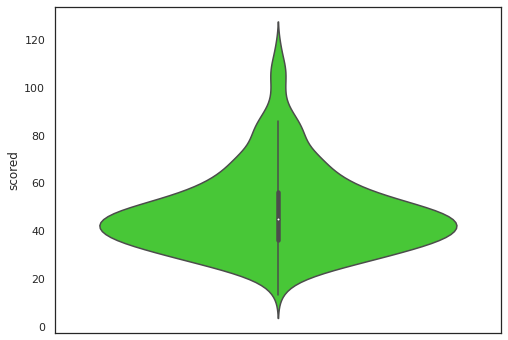

In [ ]:
plt.figure(figsize=(8,6))
sns.violinplot(y=stats.scored, bins = 150, color = verde)

* Una gran mayoría de equipos consiguen meter de 35 a 50 goles por temporada. Luego hay pocos equipos que hayan metido mas de 90 goles (probablemente los que clasifican a copas europeas) y pocos que meten menos de 25

# Distribucion de goles esperados por temporada

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


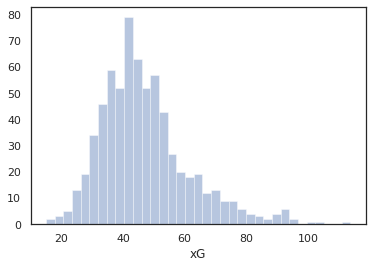

In [ ]:
sns.distplot(stats.xG.dropna(), kde=False, bins = 35)

Se puede destacar que, como es esperable, la mayoria de equipos a lo largo de las ligas analizadas posee una cantidad de goles esperados que ronda los 35 aproximadamente hacia los 55. La cantidad de equipos que a lo largo de una temporada superan los 80 es poca, hay una asimetría hacia la derecha.

# Distribucion de los goles concedidos por temporada

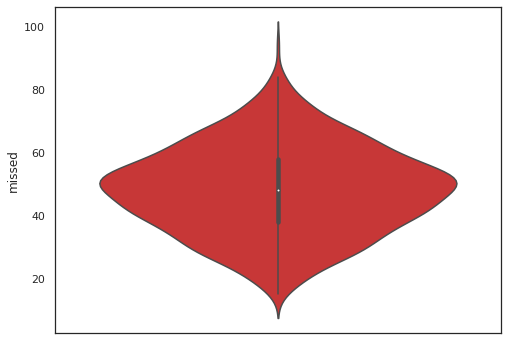

In [ ]:
plt.figure(figsize=(8,6))
sns.violinplot(y=stats.missed, bins=150, color = rojo)

* A una gran mayoría de equipos le consiguen meter de 40 a 60 goles por temporada. Luego no hay muchos a los que le metan mas de 80 y menos de 20

# Recuento de los goles anotados en un partido

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


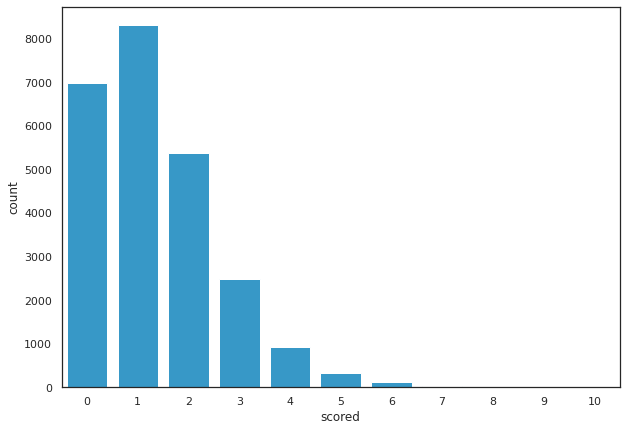

In [ ]:
plt.figure(figsize=(10,7))
sns.countplot(stats_per_game.scored, color = celeste)

* Esto es un claro indicador de que los resultados mas comunes en un partido son con ambos equipos metiendo de 0 a 2 goles (por ejemplo, 0-1, 1-2, 2-0, 1-1 ...)

# Distribucion de los pases permitidos por accion defensiva en ataque y en defensa

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


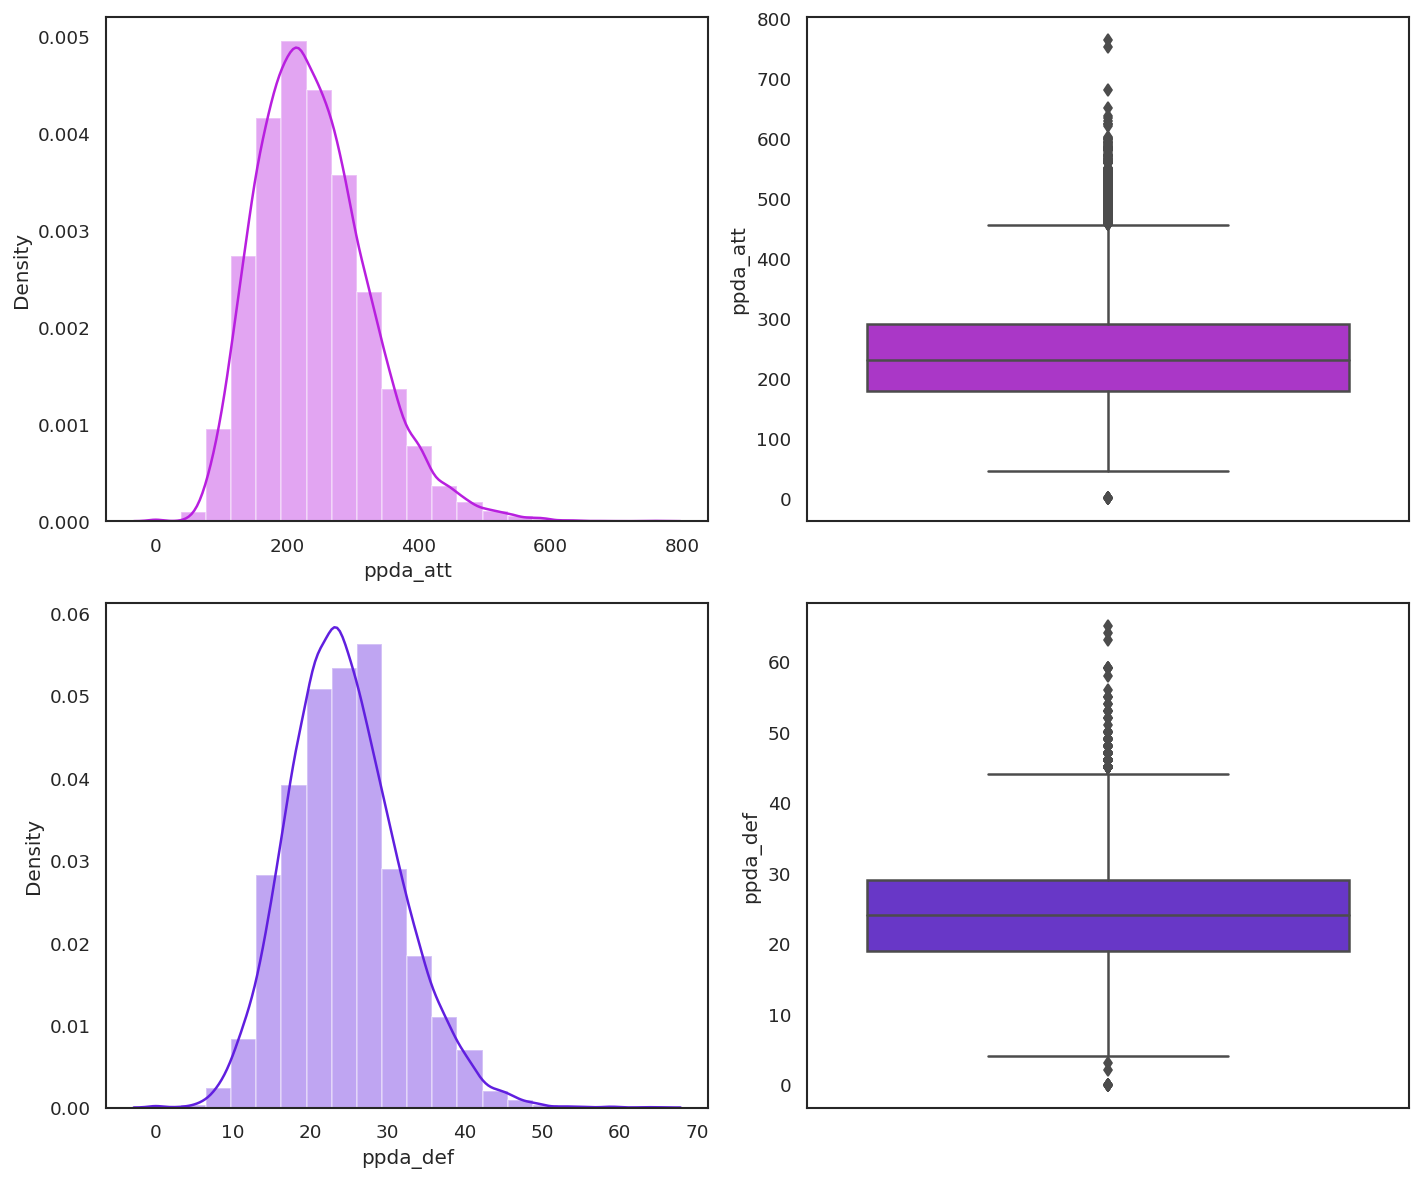

In [ ]:
fig,axes = plt.subplots(nrows=2,ncols=2,dpi=120,figsize = (12,10))

plot0 = sns.distplot(stats_per_game['ppda_att'], ax=axes[0,0], bins = 20, color = magenta)
plt.tight_layout()

plot1 = sns.boxplot(y=stats_per_game['ppda_att'], ax=axes[0,1], color = magenta)
plt.tight_layout()

plot3 = sns.distplot(stats_per_game['ppda_def'], ax=axes[1,0], bins = 20, color = violeta)
plt.tight_layout()

plot4 = sns.boxplot(y=stats_per_game['ppda_def'], ax=axes[1,1], color = violeta)
plt.tight_layout()

#Analisis bivariado

# Correlacion de las variables

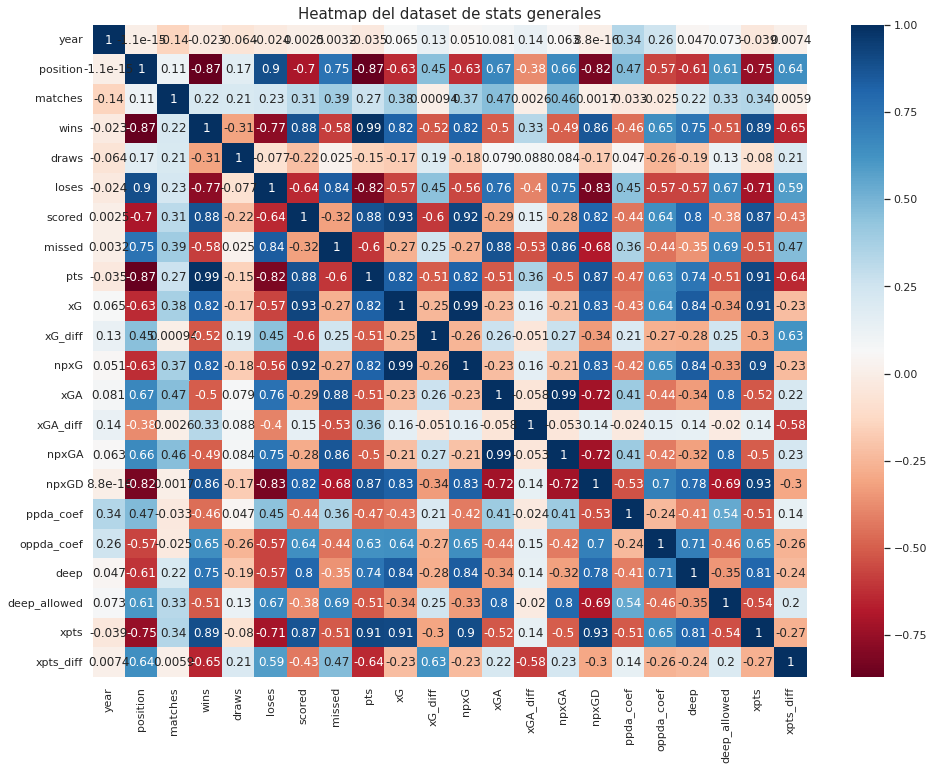

In [ ]:
plt.rcParams['figure.figsize'] = (16, 12)

sns.heatmap(stats.corr(), annot = True, cmap = 'RdBu')
plt.title('Heatmap del dataset de stats generales', fontsize = 15)
plt.show()

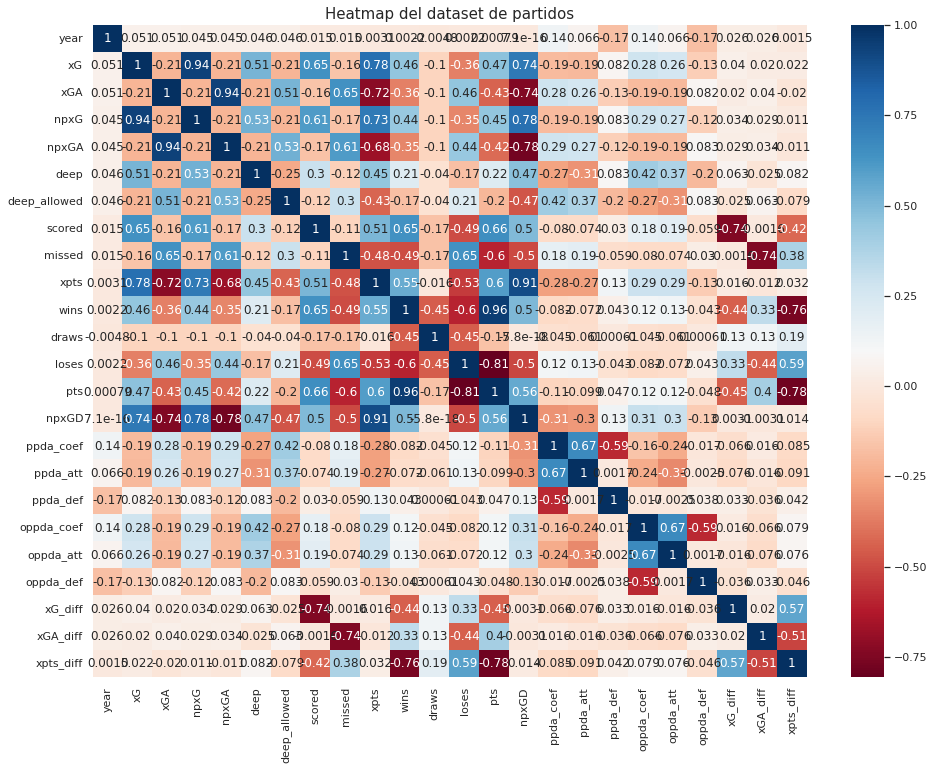

In [ ]:
plt.rcParams['figure.figsize'] = (16, 12)

sns.heatmap(stats_per_game.corr(), annot = True, cmap = 'RdBu')
plt.title('Heatmap del dataset de partidos', fontsize = 15)
plt.show()

# Goles anotados y concedidos en relacion al promedio de puntos obtenidos

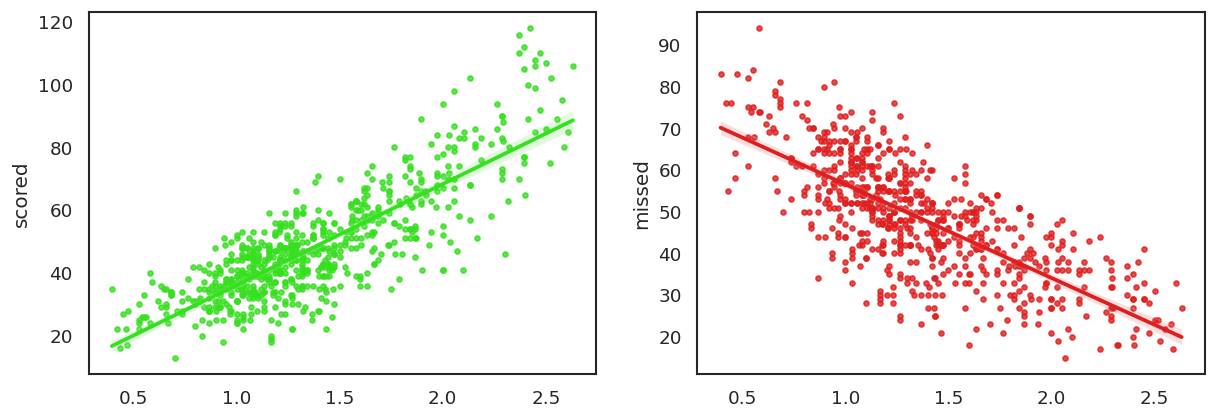

In [ ]:
fig,axes = plt.subplots(nrows=1,ncols=2,dpi=120,figsize = (12,4))

plot0 = sns.regplot(data = stats, x = promedio_de_puntos, y = "scored", ax=axes[0], color = verde, marker = '.')
plot1 = sns.regplot(data = stats, x = promedio_de_puntos, y = "missed", ax=axes[1], color = rojo, marker = '.')

* El promedio de puntos parece estar muy relacionado con la cantidad de goles metidos y concedidos: cuantos mas goles mete un equipo, mayor promedio de puntos tiene en la temporada. Analogamente, cuantos mas goles le meten, menos victorias y por ende menos puntos.
* Otra observacion interesante es que hay valores mas altos en goles metidos, esto es porque por lo general, en una liga no hay mas equipos goleadores que equipos goleados, porque en ese caso la competencia seria muy pareja en los puestos mas altos y esto nunca es así: siempre hay no mas de 4 equipos que sacan grandes diferencias y golean.

# Distribucion del promedio de gol de los equipos por liga

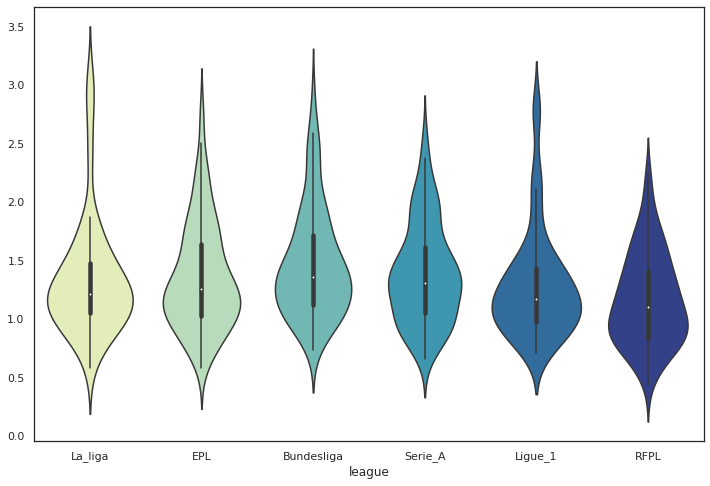

In [ ]:
plt.figure(figsize=(12,8))
sns.violinplot(data = stats, x = "league", y = promedio_de_goles, palette = paleta1)

* Parece que el promedio de gol por partido de los equipos en 
las 6 ligas analizadas rondan mayormente entre 0,75 y 1,75. Esto nos dice que en la mayoria de los partidos, un equipo mete entre 0 y 2 goles.
* Luego, por lejos la RFPL parece ser una liga donde no se meten tantos goles: tiene el menor pico de todas las ligas y los promedios mas bajos, ademas de ser la que tiene su mayor distribucion en el menor valor de todas las ligas (alrededor de 1).
* Finalmente, La Liga, Bundesliga y Ligue 1 son quienes abarcan un mayor rango de valores, posiblemente son ligas con gran diferencia entre equipos aspirantes a clasificar a copas europeas y equipos que pelean el descenso. Esto tendrá que verse cuando se analice, por ejemplo, la cantidad y distribucion de las denominadas "goleadas" (partidos en los que un equipo gana por mas de 3  goles o partidos en los que un equipo sale victorioso pero le metieron mas de 3 goles, por ejemplo un 4-0, un 5-3, o un 5-1)

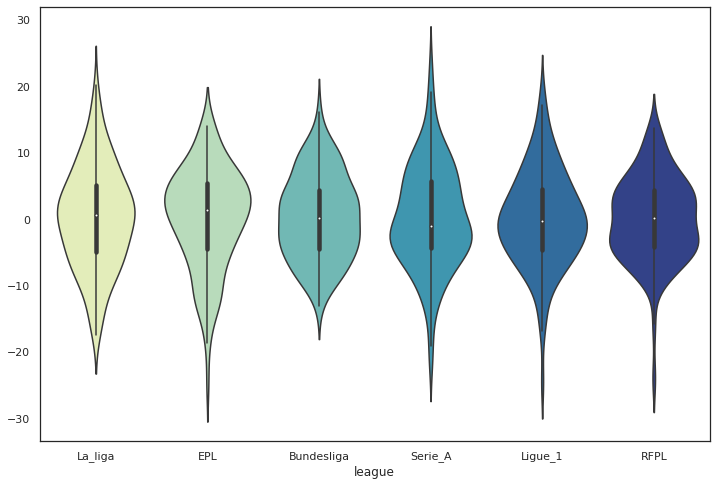

In [ ]:
plt.figure(figsize=(12,8))
sns.violinplot(data = stats, x = "league", y = diferencia_de_puntos, palette = paleta1)

*   En este grafico se puede apreciar que la Bundesliga es la que menor variacion presenta entre los puntos esperados y los que efectivamente se obtienen. 
*   La Premier League (EPL) es la que mayor diferencia presenta en el caso de que los puntos actuales superan los esperados.

# Relacion entre la diferencia entre goles esperados a favor y en contra en las diferentes ligas

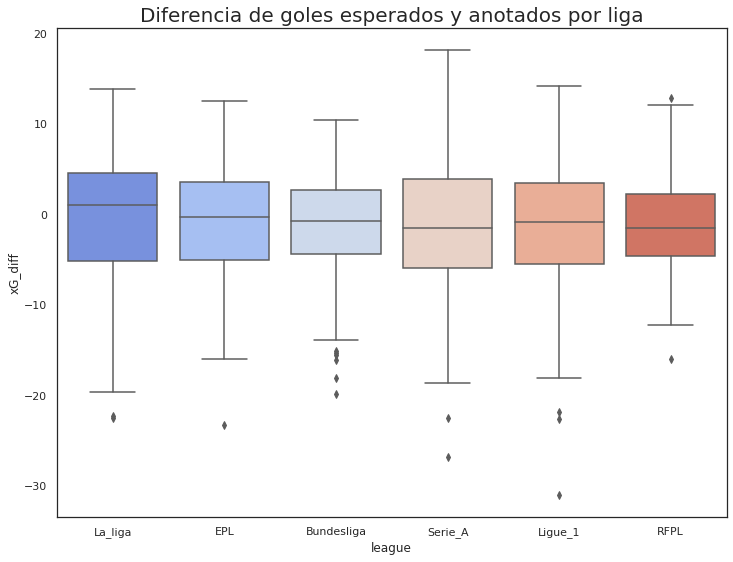

In [ ]:
plt.rcParams['figure.figsize'] = (12, 9)
sns.boxplot(x=stats['league'], y=stats['xG_diff'], palette = 'coolwarm')
plt.title('Diferencia de goles esperados y anotados por liga', fontsize = 20)
plt.show()

*   La Bundesliga y la RFPL son los que menor variacion presentan respecto de los goles esperados a favor y en contra. Se pueden asumir que hay partidos con muchas situaciones de gol para ambos equipos.
*   La Serie A es la que mayor amplitud entre los valores produce. Esto implica que hay mayor disparidad entre los equipos, ya que hay algunos que generan muchas jugadas de gol a favor pero tienen pocas en contra, y también algunos de mal rendimiento, que presentan la situacion inversa.

# Relaciones existentes entre xG y xGA con respecto a la posición final

Text(0.5, 1.0, 'Relacion entre xG y posicion final')

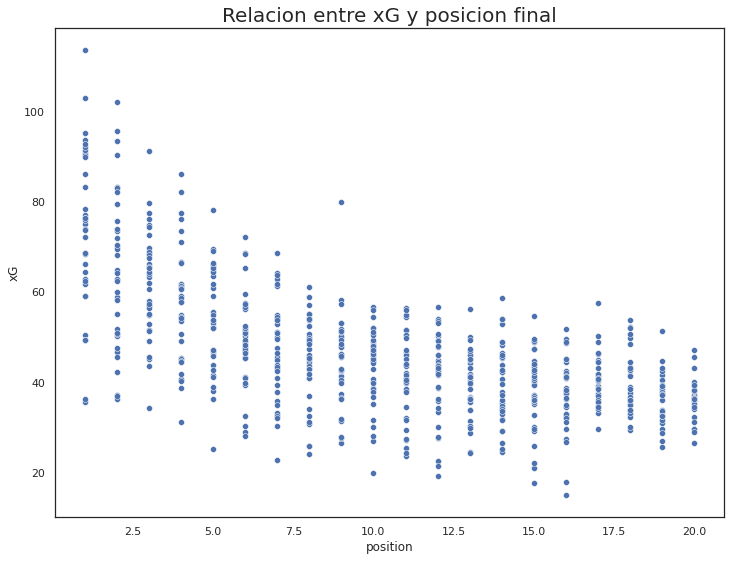

In [ ]:
sns.scatterplot(x="position", y="xG", data=stats)
plt.title('Relacion entre xG y posicion final', fontsize = 20, fontweight = 30)

La correlacion no es directamente lineal, y en las posiciones medias o cercanas a las finales la diferencia no es perceptible, la pendiente es cercana a 0. Se puede decir que la relación enre goles esperados y la posición final es proporcional hasta la posición 7/8, luego de eso la relación no es tan clara.

Text(0.5, 1.0, 'Relacion entre xG en contra y posicion final')

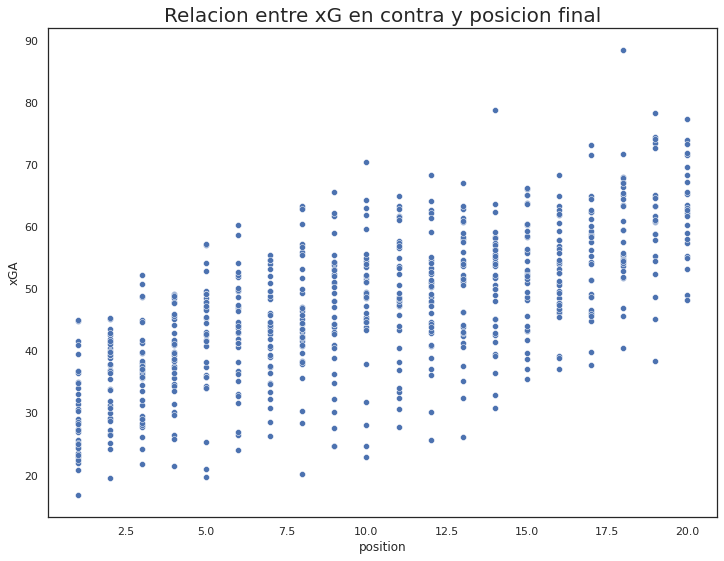

In [ ]:
sns.scatterplot(x="position", y="xGA", data=stats)
plt.title('Relacion entre xG en contra y posicion final', fontsize = 20, fontweight = 30)

Similar al gráfico anterior, para las posiciones principales y las últimas, hay una linealidad entre a mayor xGA peor será la posición final. Aunque, para la zona media que abarca las posiciones 7-8 hasta la 12-13 no es posible establecer la misma conclusión.

# Analisis multivariado

#Promedio de goles y puntos

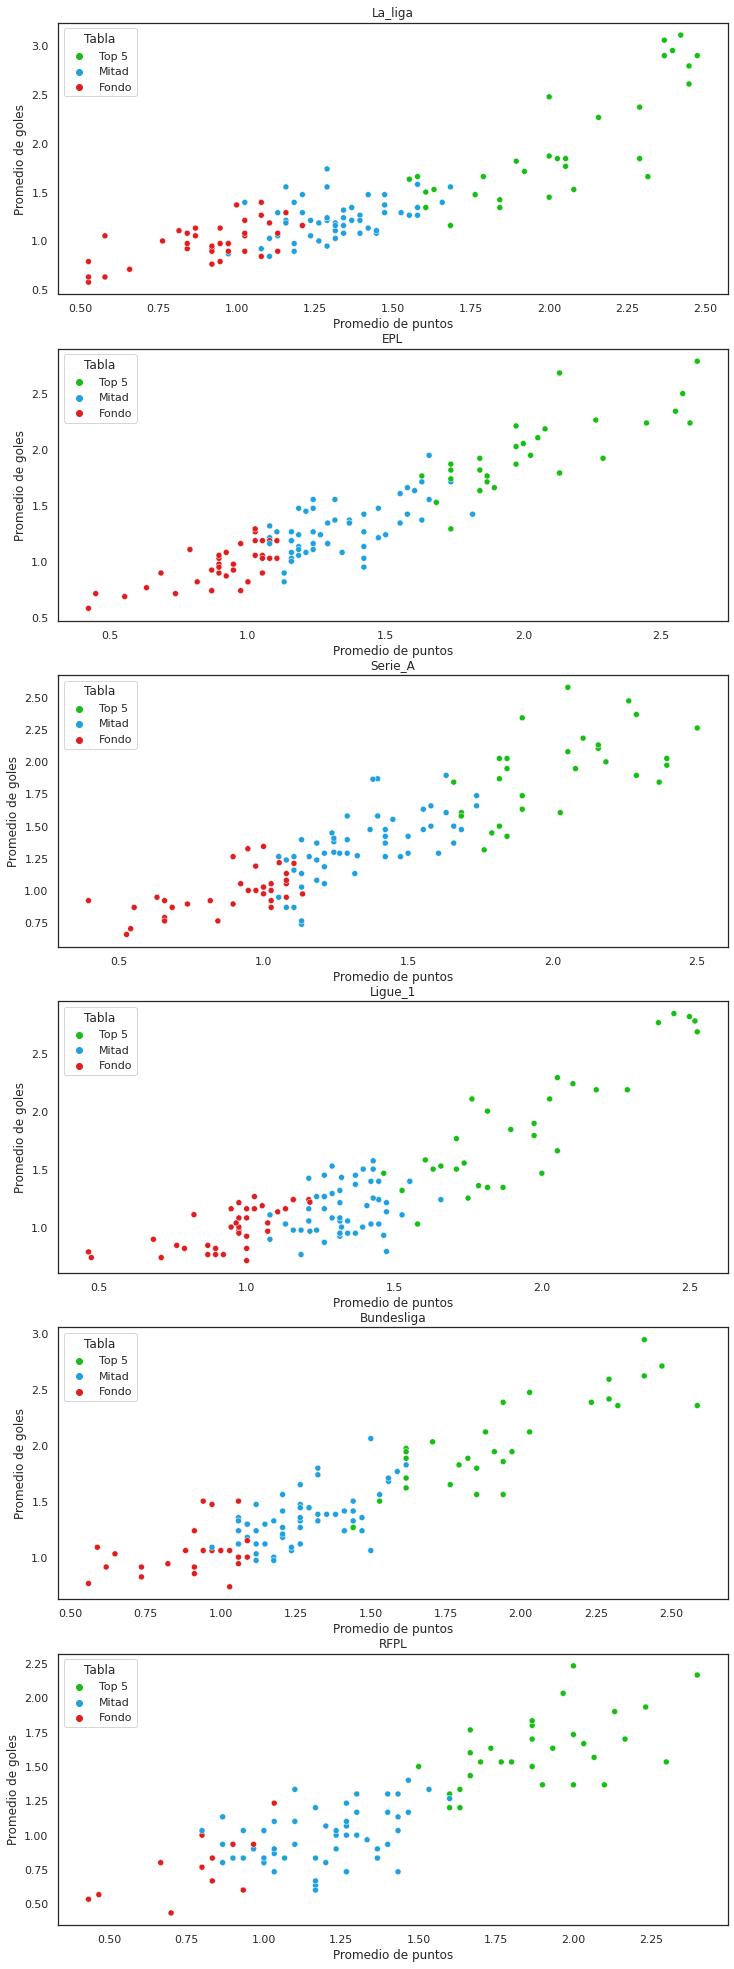

<Figure size 500x400 with 0 Axes>

In [ ]:
leagues = stats['league'].value_counts().index

fig, axes = plt.subplots(len(leagues), 1, figsize=(12,35))
plt.figure(dpi = 100, figsize = (5,4))

for ax, l in zip(axes, leagues):
    ax = sns.scatterplot(data = stats[stats['league'] == l], x = promedio_de_puntos, y = promedio_de_goles, hue = 'Tabla', palette = paleta3, ax=ax)
    ax.set_title(f'{l}', fontsize = 12)
    ax.set_xlabel('Promedio de puntos')
    ax.set_ylabel('Promedio de goles')

# Relación entre goles esperados a favor y en contra

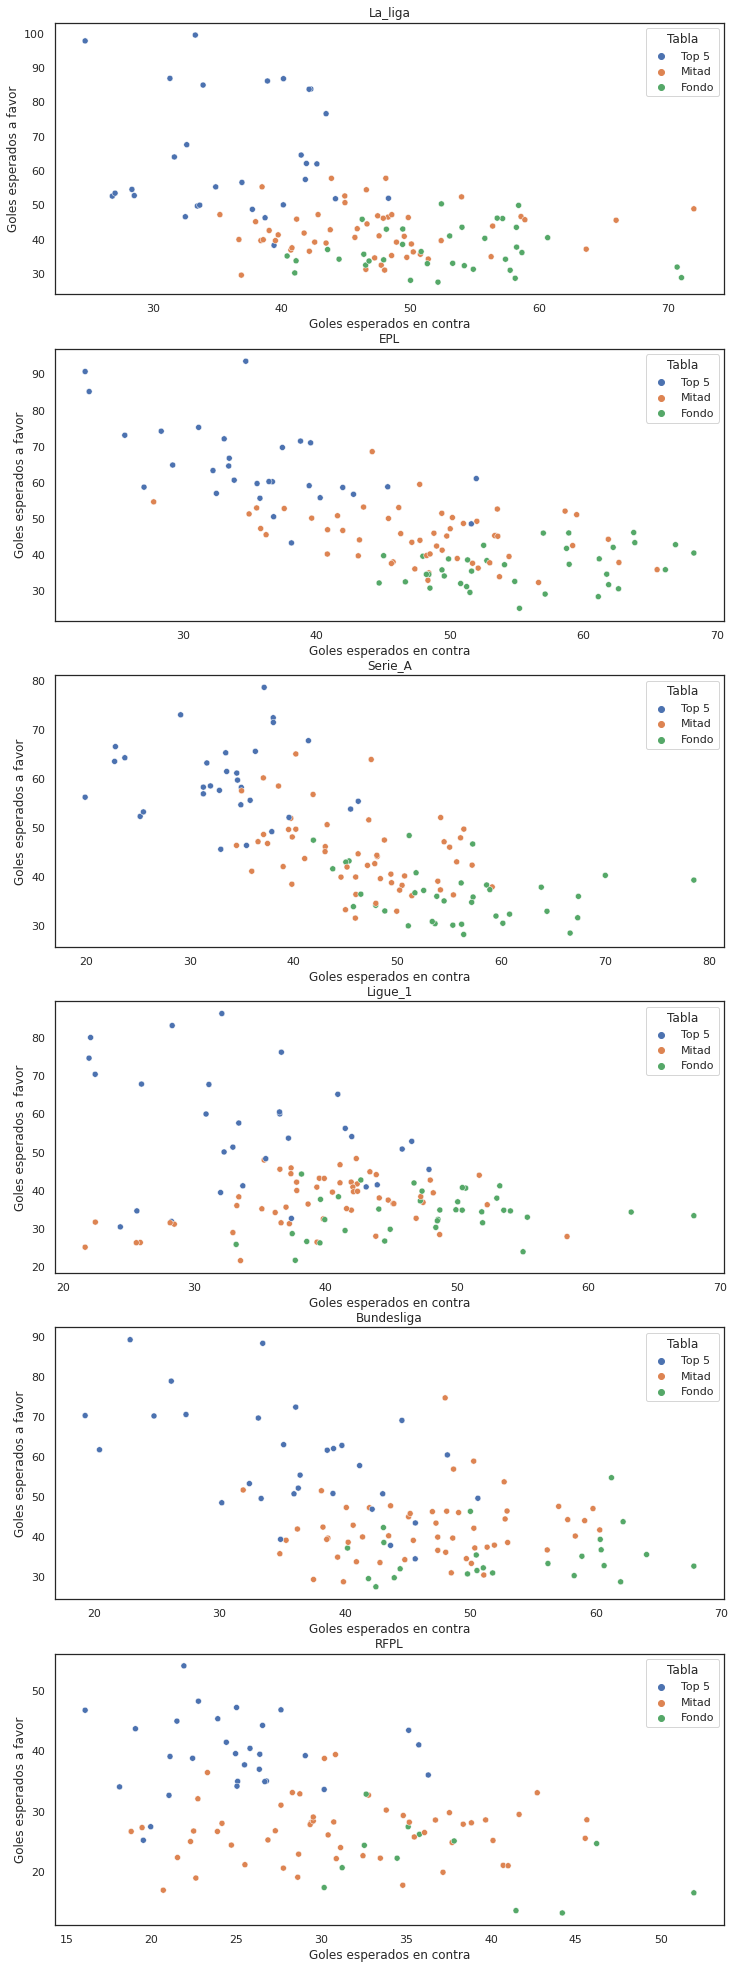

<Figure size 500x400 with 0 Axes>

In [ ]:
leagues = stats['league'].value_counts().index

fig, axes = plt.subplots(len(leagues), 1, figsize=(12,35))
plt.figure(dpi = 100, figsize = (5,4))

for ax, l in zip(axes, leagues):
    ax = sns.scatterplot(data = stats[stats['league'] == l], x = stats['npxGA'], y = stats['npxG'], hue = 'Tabla', ax=ax)
    ax.set_title(f'{l}', fontsize = 12)
    ax.set_xlabel('Goles esperados en contra')
    ax.set_ylabel('Goles esperados a favor')

De acuerdo a lo esperado, los equipos de quienes terminan entre los primeros de cada liga, son los que mas goles esperados a favor y menos en contra tienen. Algunas cuestiones a destacar:

* En la Liga de España se observa gran diferencia entre los equipos principales 
respecto de los otros en ambas categorías. Fuera de esos equipos, la principal característica influyente es la de goles esperados en contra, es decir, su nivel defensivo.
* La English Premier League presenta una relacion bastante más lineal en lo que respecta a goles esperados a favor y en contra. La Serie A presenta un comportamiento similar.
* En la Ligue 1 equipos con muy pobre nivel ofensivo han podido mantener la categoria en base a su buen nivel defensivo.

# Profundidad de los equipos segun su posicion relativa en la tabla

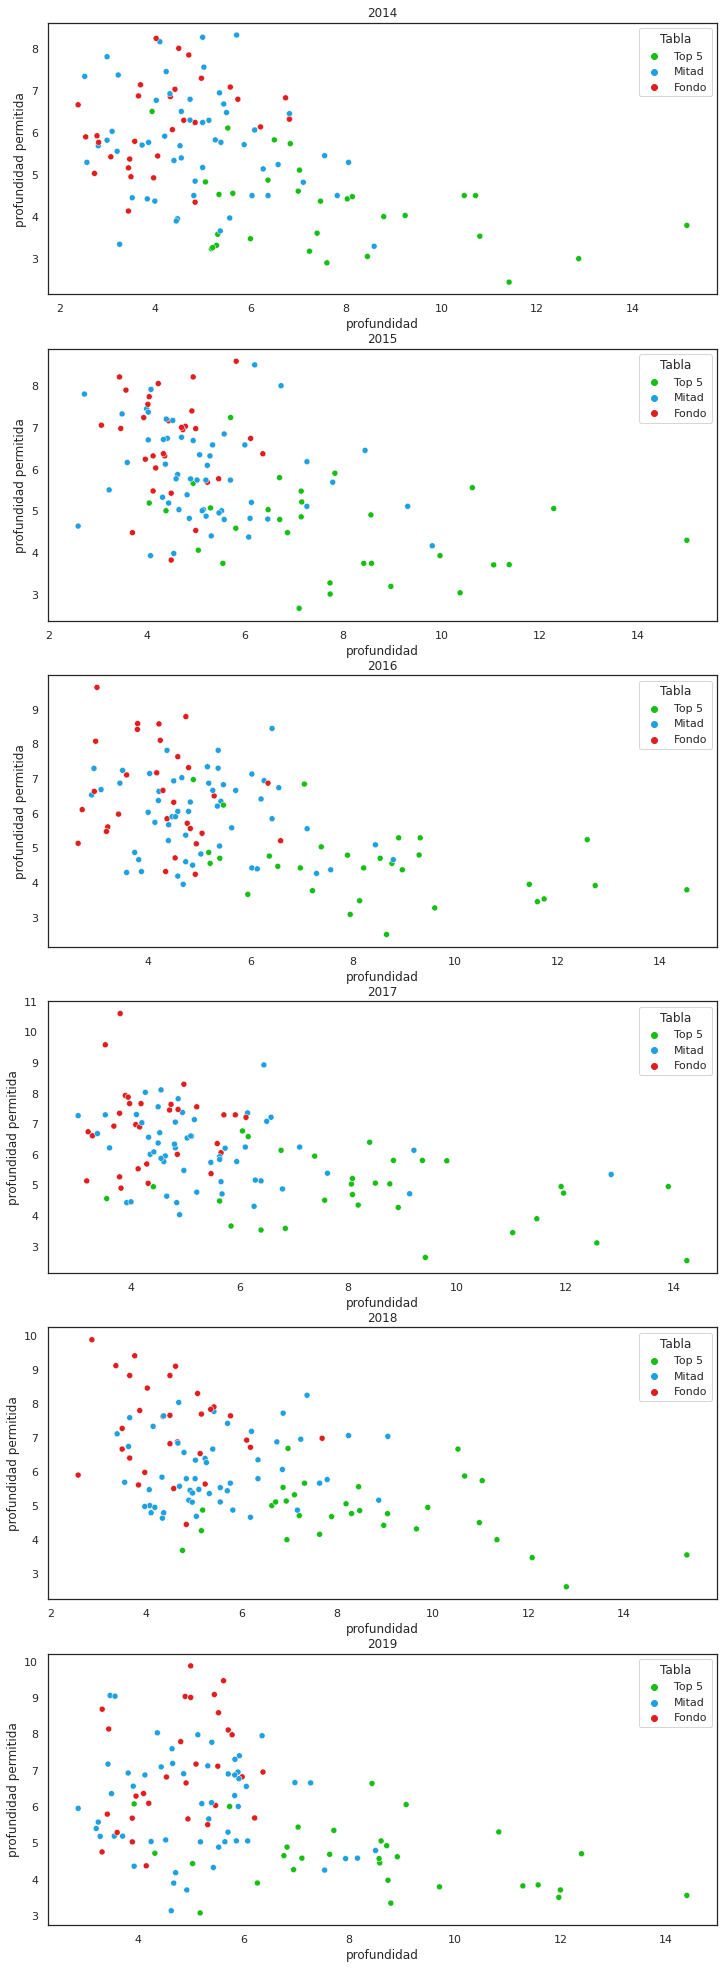

<Figure size 500x400 with 0 Axes>

In [ ]:
profundidad = stats.deep / stats.matches
profundidad_permitida = stats.deep_allowed / stats.matches
liga_temporada = stats['league'] + stats["year"].astype(str)
stats['liga_temporada'] = stats['league'] + '' + stats['year'].astype(str)
temporadas = stats['year'].value_counts().index

fig, axes = plt.subplots(len(temporadas), 1,  figsize=(12,35))
plt.figure(dpi = 100, figsize = (5,4))
for ax, n in zip(axes, temporadas):
      ax = sns.scatterplot(data = stats[stats['year'] == n], x = profundidad, y = profundidad_permitida, hue = 'Tabla', palette = paleta3, ax=ax)
      ax.set_title(f'{n}', fontsize = 12)
      ax.set_xlabel('profundidad')
      ax.set_ylabel('profundidad permitida')

Claramente los equipos top 5 son los que más pases hacen en los últimos metros del campo rival (profundidad) y que menos pases les hacen sus rivales cerca del arco (profundidad permitida). Esto es muy notorio en cualquiera de las temporadas analizadas, aunque no tanto en el 2014 y 2015.

# Diferencia de puntos obtenidos vs los esperados

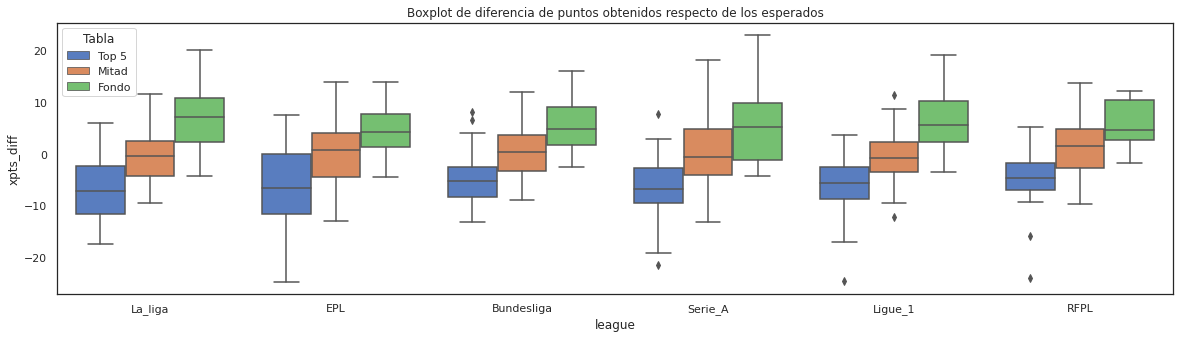

In [ ]:
plt.figure(figsize=(20,5))
sns.boxplot(x='league',y='xpts_diff', data=stats, palette='muted', hue='Tabla')
plt.title('Boxplot de diferencia de puntos obtenidos respecto de los esperados')
plt.show()

* Top 5 Teams: los equipos de la RFPL presentan la menor variacion respecto de los puntos esperados. En la Bundesliga y la Ligue 1 se observan las menores variaciones. La media de RFPL es superior a las otras, mientras que las de la Liga de España son inferiores a cualquier otra.
* Todo lo restante tiene comportmiento no muy diferente entre las ligas.
Tiene sentido que en todos los casos, mientras peor es el equipo, mayor es la diferencia entre puntos obtenidos en relación a los que se espera, basicamente por la forma y estilo de jugar (generalmente dominados, pocas situaciones de gol, muchas jugadas de gol en contra, etc.)

Text(0.5, 1.0, 'Promedio de goles en contra por temporada')

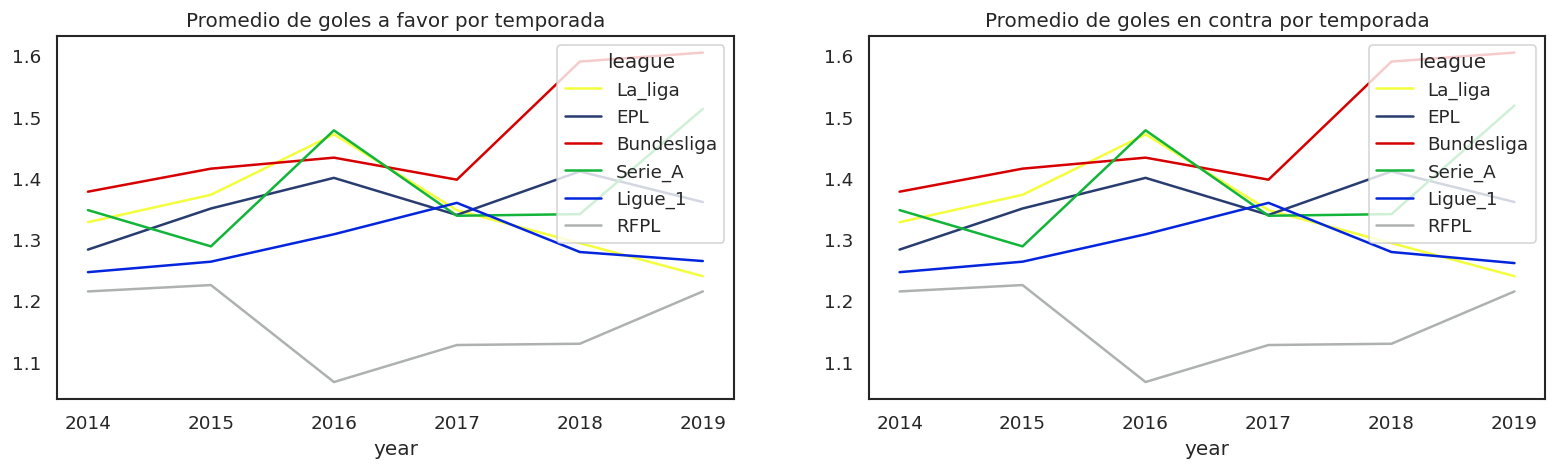

In [ ]:
fig,axes = plt.subplots(nrows=1,ncols=2,dpi=120,figsize = (16,4))

plot0 = sns.lineplot(data = stats, x = 'year', y = promedio_de_goles, hue = 'league', ci = None, palette = paleta4, ax=axes[0])
axes[0].set_title('Promedio de goles a favor por temporada')

plot1 = sns.lineplot(data = stats, x = 'year', y = promedio_de_goles_concedidos, hue = 'league', ci = None, palette = paleta4, ax=axes[1])
axes[1].set_title('Promedio de goles en contra por temporada')

La liga de Rusia (RFPL) es la menos goleadora de todas en casi todos los años analizados. 
Por otro lado, la Bundesliga es la liga con mayor promedio de gol en todos los años exceptuando 2016. En esta liga tal vez la brecha entre los de arriba y abajo de al tabla sea la mayor de las 6 ligas.

# Conclusiones del Analisis


Como conclusión se puede analizar que las ligas analizadas, en muchos factores tienen comportamientos similares (a excepción de la liga rusa). Naturalmente existen diferencias propias de los equipos que participan, pero particularmente en los gráficos que divide en base a clasificacion dada por la posicion en la tabla, se puede observar con facilidad que en todas de ellas los primeros 5 poseen un comportamiento diferente respecto de los ultimos, que a su vez presentan un comportamiento diferente al del resto de los equipos, pero con diferencias no tan marcadas. Este fenómeno es apreciable en al menos 5 de las principales ligas europeas.


# Prediccion sobre la posicion del equipo en la tabla basado en sus movimientos en el mercado de fichajes de verano

De momento, hemos decidido que nuestra variable a predecir es la posicion (o seccion de la tabla) de un equipo al finalizar la temporada. Nuestras predicciones seran basadas en las variables relacionadas al movimiento del mercado (valor de los jugadores incorporados, valor de los jugadores vendidos, suma del valor de los jugadores de una misma posicion) y en la posicion promedio de ese equipo en las temporadas analizadas.

En el futuro, se agregarán variables como las rachas de los equipos, la posicion de la temporada anterior, entre otras, para un mejor analisis.

# KNN

Prediccion sobre si un equipo es o no del fondo de la tabla basado en su posicion promedio historica (años analizados) con el valor economico incorporado a la plantilla ese año

In [60]:
dt_knn1 = result.drop(columns=["team_year","pts","position_x","avg_age_of_new_players", "league", "year", "deep",
                                   "scored","missed","oppda_coef", "deep_allowed", "wins", "ppda_coef", "team", "draws", "loses", "matches", "xG", "xG_diff", "npxG", "xGA", "xGA_diff", 
                                   "npxGA", "npxGD", "xpts", "xpts_diff","amount_new_defenders","amount_new_attackers"])
dt_knn1.head(5)

,Tabla1,Tabla2,value_added_to_team,value_of_new_def,value_of_new_att,avg_position
0,Top 4,resto,111500000.0,1500000.0,48000000.0,2.833333
1,Top 4,resto,105000000.0,15000000.0,9000000.0,2.833333
2,Top 4,resto,174000000.0,0.0,35000000.0,2.833333
3,Top 4,resto,197900000.0,45000000.0,70000000.0,2.833333
4,Mitad,resto,68200000.0,14000000.0,12000000.0,5.166667


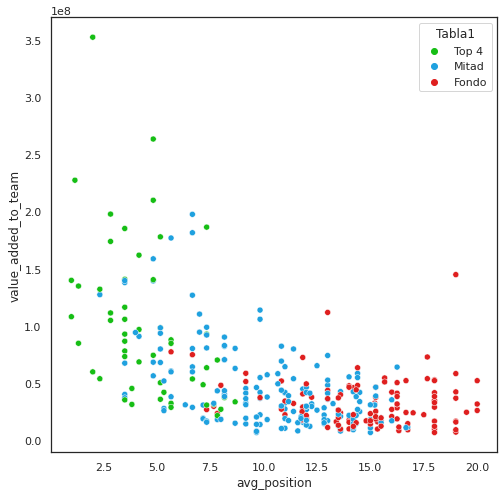

In [ ]:
plt.figure(figsize = (8,8))
sns.scatterplot(data = dt_knn1, x = 'avg_position', y = 'value_added_to_team', hue = 'Tabla1', palette = paleta3)

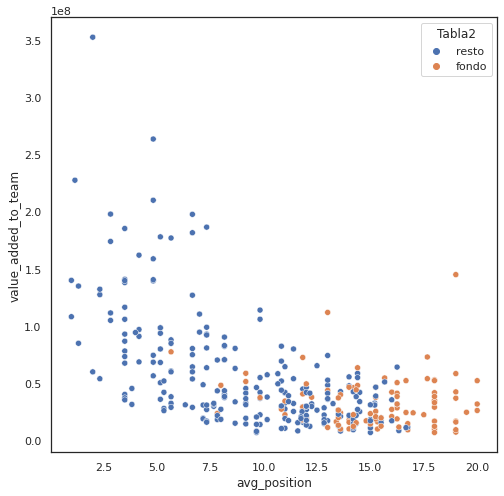

In [ ]:
plt.figure(figsize = (8,8))
sns.scatterplot(data = dt_knn1, x = 'avg_position', y = 'value_added_to_team', hue = 'Tabla2')

In [61]:
X = dt_knn1[['avg_position', 'value_added_to_team']]
y = dt_knn1[['Tabla2']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=48)

In [62]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=15)

In [63]:
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)
print(knn.predict(X_test))

['resto' 'resto' 'resto' 'resto' 'resto' 'resto' 'resto' 'resto' 'resto'
 'resto' 'resto' 'resto' 'resto' 'resto' 'resto' 'fondo' 'resto' 'resto'
 'resto' 'resto' 'resto' 'resto' 'resto' 'resto' 'resto' 'resto' 'resto'
 'resto' 'resto' 'resto' 'resto' 'resto' 'resto' 'resto' 'resto' 'resto'
 'resto' 'resto' 'resto' 'resto' 'resto' 'resto' 'resto' 'resto' 'resto'
 'resto' 'resto' 'resto' 'resto' 'resto' 'resto' 'resto' 'resto' 'resto'
 'resto' 'resto' 'resto' 'fondo' 'resto' 'resto' 'resto' 'resto' 'resto'
 'resto' 'resto' 'resto' 'resto' 'resto' 'resto' 'resto' 'resto' 'resto'
 'resto' 'resto' 'resto' 'resto' 'resto' 'resto' 'resto' 'resto' 'resto'
 'resto' 'resto' 'resto' 'resto' 'resto']


In [64]:
print(knn.score(X_test, y_test))

0.6511627906976745


In [65]:
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print('% de aciertos sobre el set de entrenamiento:', train_accuracy)
print('% de aciertos sobre el set de evaluación:', test_accuracy)

% de aciertos sobre el set de entrenamiento: 0.7674418604651163
% de aciertos sobre el set de evaluación: 0.6511627906976745


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

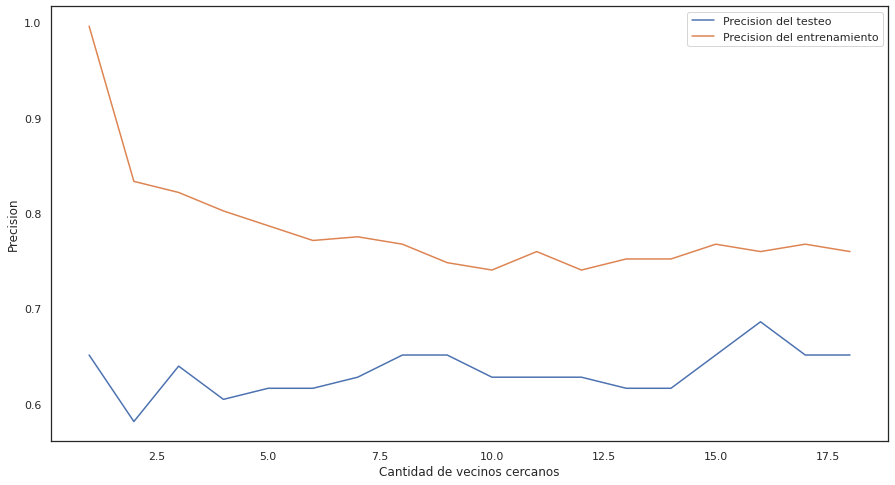

In [66]:
vecinos = np.arange(1, 19)
train_accuracy2 = np.empty(len(vecinos))
test_accuracy2 = np.empty(len(vecinos))

for i, k in enumerate(vecinos):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
     
    train_accuracy2[i] = knn.score(X_train, y_train)
    test_accuracy2[i] = knn.score(X_test, y_test)
 
plt.figure(figsize=(15,8))
plt.plot(vecinos, test_accuracy2, label = 'Precision del testeo')
plt.plot(vecinos, train_accuracy2, label = 'Precision del entrenamiento')
 
plt.legend()
plt.xlabel('Cantidad de vecinos cercanos')
plt.ylabel('Precision')
plt.show()

No mucha precision para este modelo, pues independientemente de la cantidad de vecinos que probemos, apenas alcanza el 70% de efectividad  

# HDBSCAN

In [ ]:
from mpl_toolkits import mplot3d
from hdbscan import HDBSCAN

In [ ]:
dt_knn1.head()

,Tabla,value_added_to_team,value_of_new_def,value_of_new_att,avg_position
0,Top 5,111500000.0,1500000.0,48000000.0,2.833333
1,Top 5,105000000.0,15000000.0,9000000.0,2.833333
2,Top 5,174000000.0,0.0,35000000.0,2.833333
3,Top 5,197900000.0,45000000.0,70000000.0,2.833333
4,Top 5,68200000.0,14000000.0,12000000.0,5.166667


In [ ]:
dt_knn2 = result.drop(columns=["team_year","pts","avg_age_of_new_players", "league", "year", "deep",
                              "scored","missed","oppda_coef", "deep_allowed", "wins", "ppda_coef", "team", "draws", "loses",
                              "matches", "xG", "xG_diff", "npxG", "xGA", "xGA_diff", "value_added_to_team","position_x","value_of_new_att",
                              "npxGA", "npxGD", "xpts", "xpts_diff","amount_new_defenders","amount_new_attackers","Tabla"])

In [ ]:
dt_knn2

,value_of_new_def,avg_position
0,1500000.0,2.833333
1,15000000.0,2.833333
2,0.0,2.833333
3,45000000.0,2.833333
4,14000000.0,5.166667
...,...,...
339,9000000.0,11.750000
340,350000.0,13.500000
341,3500000.0,13.500000
342,35000000.0,1.166667


In [ ]:
hdbscan = HDBSCAN(min_cluster_size=20, min_samples=10, cluster_selection_epsilon=0.01)
preds = hdbscan.fit_predict(dt_knn2)

In [ ]:
preds

array([ 1,  0,  1, -1,  0,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1, -1, -1, -1,  0,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
       -1, -1, -1,  0, -1,  0,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1, -1, -1,  1,  1,
        1,  1, -1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  0, -1, -1,
        0,  1,  1,  1,  1,  1,  1, -1,  1, -1, -1,  0,  0,  1, -1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  0, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1, -1,  1,  1, -1,  0,  1,  1,  1,  1,  1,  1,  1,  1,  0,
        1,  1, -1,  1, -1, -1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  0,
        1,  1,  0,  1, -1

In [ ]:
df_cluster_hdbscan = pd.DataFrame(dt_knn2)
df_cluster_hdbscan.head()

,value_of_new_def,avg_position
0,1500000.0,2.833333
1,15000000.0,2.833333
2,0.0,2.833333
3,45000000.0,2.833333
4,14000000.0,5.166667


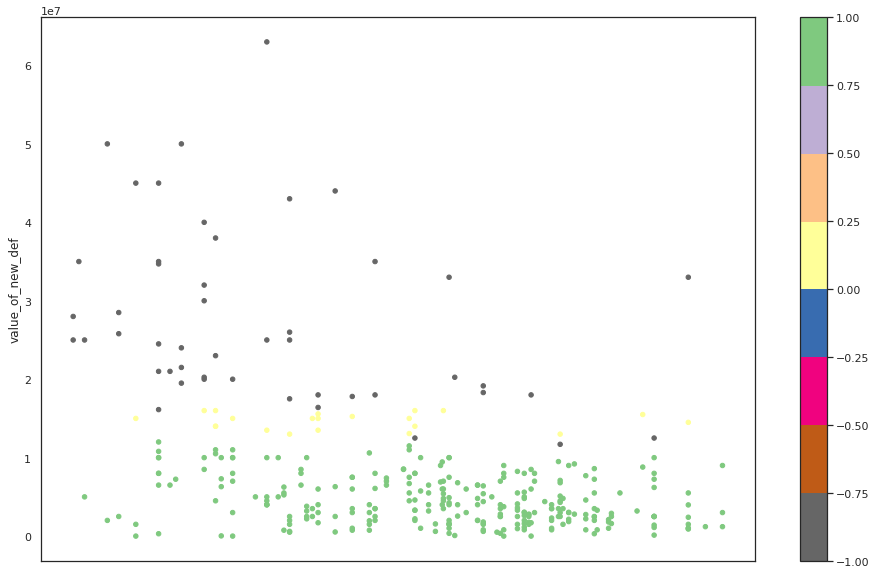

In [ ]:
df_cluster_hdbscan.plot(kind='scatter', x='avg_position', y='value_of_new_def', c=preds, cmap='Accent_r', figsize=(16,10))

In [ ]:
df_cluster_hdbscan['label'] = preds
df_cluster_hdbscan.head()

,value_of_new_def,avg_position,label
0,1500000.0,2.833333,1
1,15000000.0,2.833333,0
2,0.0,2.833333,1
3,45000000.0,2.833333,-1
4,14000000.0,5.166667,0


El modelo no ve muy en claro los grupos, pues justamente los agrupa mal (comparar con los graficos obtenidos antes en el analisis multivariado hace ver mas claro por qué está mal agrupado)

# Decission tree

In [ ]:
X = dt_knn1.drop(columns=["Tabla"])
y = dt_knn1['Tabla']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1) 

In [ ]:
tree1 = DecisionTreeClassifier(max_depth=6, random_state = 42, min_samples_split=22)
tree1.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=6, min_samples_split=22, random_state=42)

In [ ]:
y_train_pred = tree1.predict(X_train)
y_test_pred = tree1.predict(X_test)

In [ ]:
train_accuracy = accuracy_score(y_train, y_train_pred)

test_accuracy = accuracy_score(y_test, y_test_pred)

print('% de aciertos sobre el set de entrenamiento:', train_accuracy)
print('% de aciertos sobre el set de evaluación:', test_accuracy)

% de aciertos sobre el set de entrenamiento: 0.7745454545454545
% de aciertos sobre el set de evaluación: 0.6086956521739131


xgboost- probar con este modelo


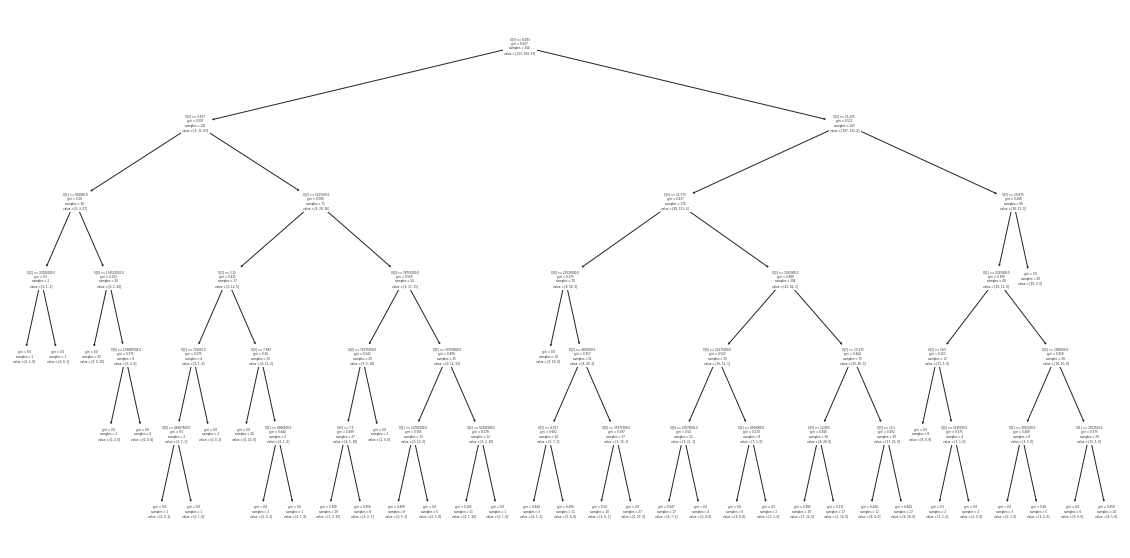

In [ ]:
rrt = DecisionTreeClassifier(max_depth=6).fit(X, y)

plt.figure(figsize=(20,10))
tree.plot_tree(rrt)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


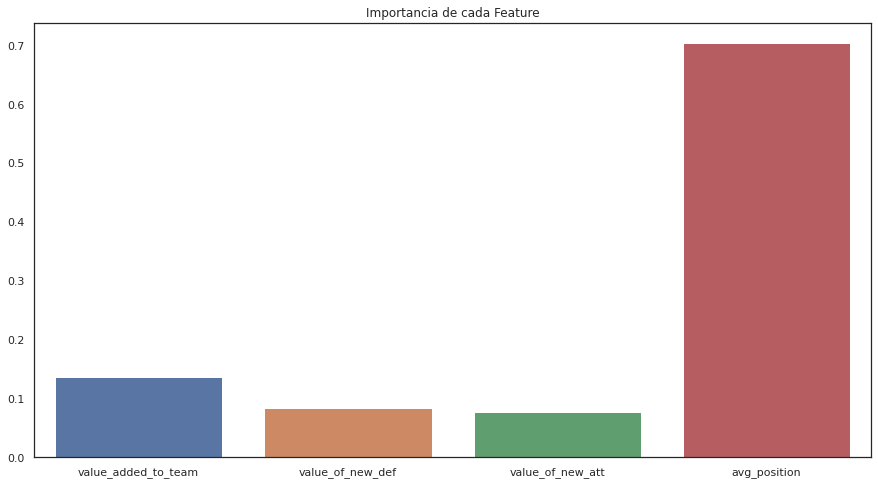

In [ ]:
plt.figure(figsize=(15,8))
importances = rrt.feature_importances_
columns = X.columns
sns.barplot(columns, importances)
plt.title('Importancia de cada Feature')
plt.show()

Hasta ahora el modelo con mejor prediccion que generamos. No es muy alto, de hecho un 70% no lo es, pero creemos que este puede ser el camino correcto.

Y las variables mas importantes y con mayor trascendencia son la posición promedio y lel valor incorporado a la plantilla

#xgBoost: top 4 y fondo

In [70]:
def tabla_result (t):
  if t['position_x'] <= 4:
    return 0
  elif t['position_x'] <= 15:
    return 1
  else:
    return 2

In [71]:
XgBoost = result.drop(columns=["team_year","pts","npxGD","npxGA", "xpts_diff","xpts", "Tabla1","avg_age_of_new_players","Tabla2", "league", "year", "deep",
                                   "scored","missed","oppda_coef", "deep_allowed", "wins", "ppda_coef", "team", "draws", "loses", "matches", "xG", "xG_diff", "npxG", "xGA", "xGA_diff" ])

In [72]:
XgBoost['position_x'] = result.apply (lambda t: tabla_result(t), axis =1)

In [73]:
XgBoost

,position_x,value_added_to_team,amount_new_defenders,value_of_new_def,amount_new_attackers,value_of_new_att,avg_position
0,0,111500000.0,1,1500000.0,2,48000000.0,2.833333
1,0,105000000.0,1,15000000.0,1,9000000.0,2.833333
2,0,174000000.0,1,0.0,1,35000000.0,2.833333
3,0,197900000.0,2,45000000.0,1,70000000.0,2.833333
4,1,68200000.0,4,14000000.0,1,12000000.0,5.166667
...,...,...,...,...,...,...,...
339,1,19250000.0,2,9000000.0,1,1750000.0,11.750000
340,1,12900000.0,2,350000.0,1,1750000.0,13.500000
341,2,13400000.0,1,3500000.0,1,1000000.0,13.500000
342,0,227500000.0,1,35000000.0,1,40000000.0,1.166667


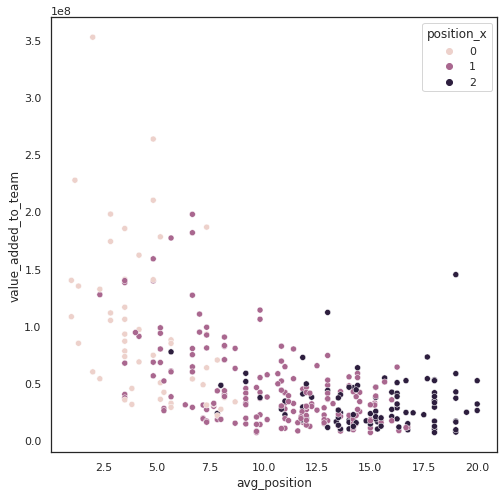

In [74]:
plt.figure(figsize = (8,8))
sns.scatterplot(data = XgBoost, x = 'avg_position', y = 'value_added_to_team', hue = 'position_x')

In [77]:
X = XgBoost.drop("position_x", axis=1) 
y = XgBoost.position_x 

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=123)

In [80]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', n_estimators=25,seed=90)

In [82]:
clf_xgb.fit(X_train,y_train)

XGBClassifier(n_estimators=25, objective='multi:softprob', seed=90)

In [83]:
y_train_pred = clf_xgb.predict(X_train) 
y_test_pred = clf_xgb.predict(X_test) 

In [85]:
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print('% de aciertos sobre el set de entrenamiento:', train_accuracy)
print('% de aciertos sobre el set de evaluación:',test_accuracy)

% de aciertos sobre el set de entrenamiento: 0.7781818181818182
% de aciertos sobre el set de evaluación: 0.7101449275362319


Matriz de confusion:

[[ 7  8  0]
 [ 3 33  4]
 [ 0  5  9]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


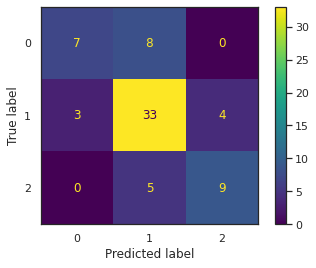

In [86]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

print(confusion_matrix(y_test, y_test_pred))
plot_confusion_matrix(clf_xgb, X_test, y_test)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


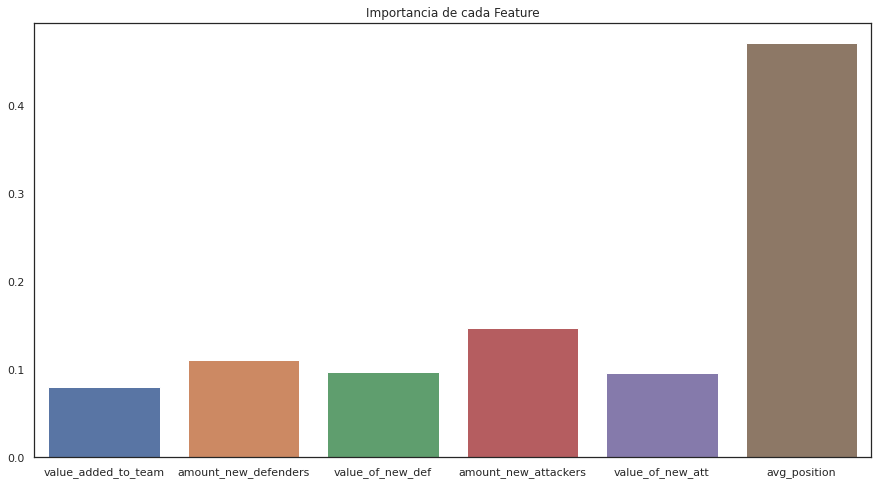

In [87]:
plt.figure(figsize=(15,8))
importances = clf_xgb.feature_importances_
columns = X.columns
sns.barplot(columns, importances)
plt.title('Importancia de cada Feature')
plt.show()

Nuevamente, la posición promedio del equipo es el factor mas determinante, seguido de la cantidad de nuevos atacantes incorporados. El valor incorporado se queda mas atrás pero sigue tomando relevancia tanto a nivel general como en defensas y atacantes por separado

#xgBoost: solo top 4

In [88]:
def tabla_result_xg2 (t):
  if t['position_x'] <=4:
    return 0
  else:
    return 1

In [89]:
XgBoost_top = result.drop(columns=["team_year","pts","npxGD","npxGA", "xpts_diff","xpts", "Tabla1","avg_age_of_new_players","Tabla2", "league", "year", "deep",
                                   "scored","missed","oppda_coef", "deep_allowed", "wins", "ppda_coef", "team", "draws", "loses", "matches", "xG", "xG_diff", "npxG", "xGA", "xGA_diff" ])

In [90]:
XgBoost_top['position_x'] = result.apply (lambda t: tabla_result_xg2(t), axis =1)

In [92]:
XgBoost_top

,position_x,value_added_to_team,amount_new_defenders,value_of_new_def,amount_new_attackers,value_of_new_att,avg_position
0,0,111500000.0,1,1500000.0,2,48000000.0,2.833333
1,0,105000000.0,1,15000000.0,1,9000000.0,2.833333
2,0,174000000.0,1,0.0,1,35000000.0,2.833333
3,0,197900000.0,2,45000000.0,1,70000000.0,2.833333
4,1,68200000.0,4,14000000.0,1,12000000.0,5.166667
...,...,...,...,...,...,...,...
339,1,19250000.0,2,9000000.0,1,1750000.0,11.750000
340,1,12900000.0,2,350000.0,1,1750000.0,13.500000
341,1,13400000.0,1,3500000.0,1,1000000.0,13.500000
342,0,227500000.0,1,35000000.0,1,40000000.0,1.166667


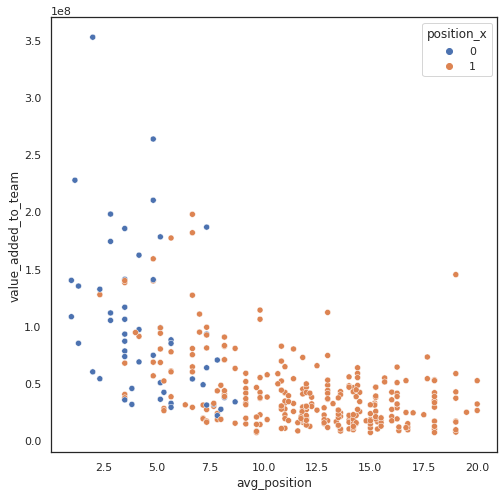

In [93]:
plt.figure(figsize = (8,8))
sns.scatterplot(data = XgBoost_top, x = 'avg_position', y = 'value_added_to_team', hue = 'position_x')

In [96]:
X = XgBoost_top.drop("position_x", axis=1)
y = XgBoost_top.position_x

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=123)

In [98]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', n_estimators=25,seed=90)

In [99]:
clf_xgb.fit(X_train,y_train)

XGBClassifier(n_estimators=25, seed=90)

In [100]:
y_train_pred = clf_xgb.predict(X_train)
y_test_pred = clf_xgb.predict(X_test)

In [102]:
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print('% de aciertos sobre el set de entrenamiento:', train_accuracy)
print('% de aciertos sobre el set de evaluación:',test_accuracy)

% de aciertos sobre el set de entrenamiento: 0.9309090909090909
% de aciertos sobre el set de evaluación: 0.855072463768116


In [103]:
from sklearn.metrics import f1_score

print(f"F1 Score of the classifier is: {f1_score(y_test, y_test_pred)}")

F1 Score of the classifier is: 0.9107142857142858


[[ 8  7]
 [ 3 51]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


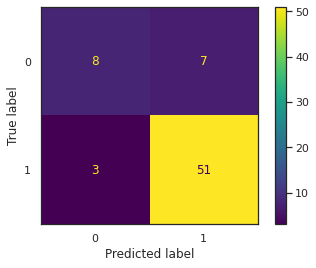

In [105]:
print(confusion_matrix(y_test, y_test_pred))

plot_confusion_matrix(clf_xgb, X_test, y_test)
plt.show()

AUC for our classifier is: 0.9148148148148147


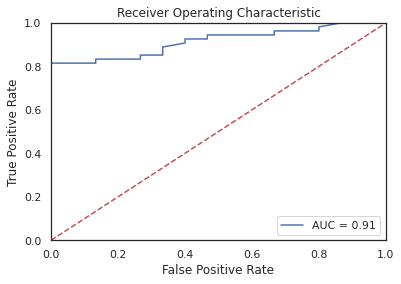

In [106]:
from sklearn.metrics import roc_curve, auc

class_probabilities = clf_xgb.predict_proba(X_test)
preds = class_probabilities[:, 1]

fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

print(f"AUC for our classifier is: {roc_auc}")

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


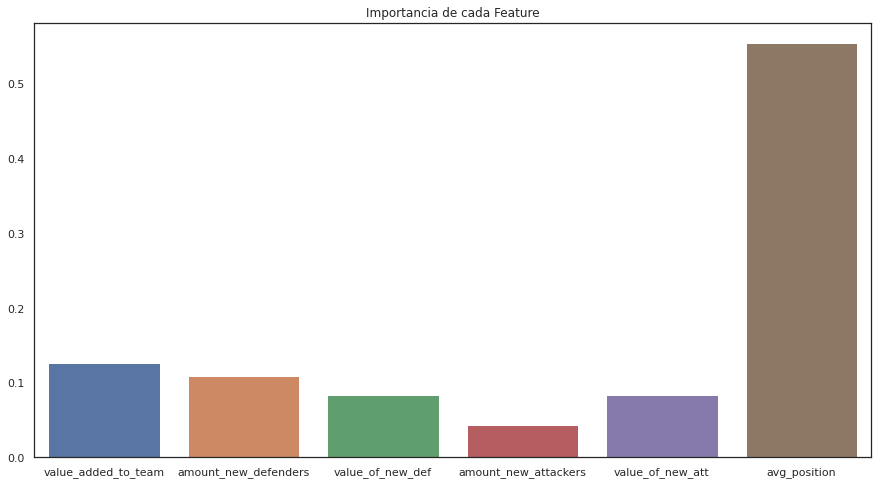

In [107]:
plt.figure(figsize=(15,8))
importances = clf_xgb.feature_importances_
columns = X.columns
sns.barplot(columns, importances)
plt.title('Importancia de cada Feature')
plt.show()

#xgBoost: solo fondo

In [108]:
def tabla_result_xg3 (t):
  if t['position_x'] >= 15:
    return 0
  else:
    return 1

In [109]:
XgBoost_bottom = result.drop(columns=["team_year","pts","npxGD","npxGA", "xpts_diff","xpts", "Tabla1","avg_age_of_new_players","Tabla2", "league", "year", "deep",
                                   "scored","missed","oppda_coef", "deep_allowed", "wins", "ppda_coef", "team", "draws", "loses", "matches", "xG", "xG_diff", "npxG", "xGA", "xGA_diff" ])

In [110]:
XgBoost_bottom['position_x'] = result.apply (lambda t: tabla_result_xg3(t), axis =1)

In [111]:
XgBoost_bottom

,position_x,value_added_to_team,amount_new_defenders,value_of_new_def,amount_new_attackers,value_of_new_att,avg_position
0,1,111500000.0,1,1500000.0,2,48000000.0,2.833333
1,1,105000000.0,1,15000000.0,1,9000000.0,2.833333
2,1,174000000.0,1,0.0,1,35000000.0,2.833333
3,1,197900000.0,2,45000000.0,1,70000000.0,2.833333
4,1,68200000.0,4,14000000.0,1,12000000.0,5.166667
...,...,...,...,...,...,...,...
339,1,19250000.0,2,9000000.0,1,1750000.0,11.750000
340,1,12900000.0,2,350000.0,1,1750000.0,13.500000
341,0,13400000.0,1,3500000.0,1,1000000.0,13.500000
342,1,227500000.0,1,35000000.0,1,40000000.0,1.166667


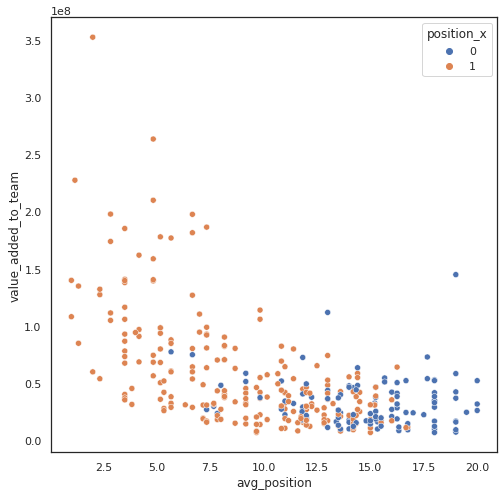

In [112]:
plt.figure(figsize = (8,8))
sns.scatterplot(data = XgBoost_bottom, x = 'avg_position', y = 'value_added_to_team', hue = 'position_x')

In [114]:
X = XgBoost_bottom.drop("position_x", axis=1)
y = XgBoost_bottom.position_x

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=123)

In [116]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', n_estimators=25,seed=90)

In [117]:
clf_xgb.fit(X_train,y_train)

XGBClassifier(n_estimators=25, seed=90)

In [118]:
y_train_pred = clf_xgb.predict(X_train)
y_test_pred = clf_xgb.predict(X_test)

In [119]:
train_accuracy = accuracy_score(y_train, y_train_pred)

test_accuracy = accuracy_score(y_test, y_test_pred)

print('% de aciertos sobre el set de entrenamiento:', train_accuracy)
print('% de aciertos sobre el set de evaluación:',test_accuracy)

% de aciertos sobre el set de entrenamiento: 0.850909090909091
% de aciertos sobre el set de evaluación: 0.7681159420289855


In [120]:
from sklearn.metrics import f1_score

print(f"F1 Score of the classifier is: {f1_score(y_test, y_test_pred)}")

F1 Score of the classifier is: 0.8400000000000001


[[11  6]
 [10 42]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


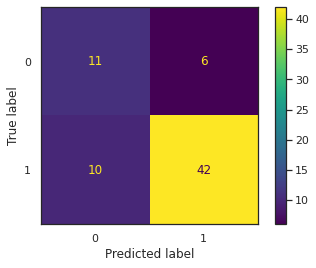

In [121]:
print(confusion_matrix(y_test, y_test_pred))

plot_confusion_matrix(clf_xgb, X_test, y_test)
plt.show()

AUC for our classifier is: 0.8320135746606335


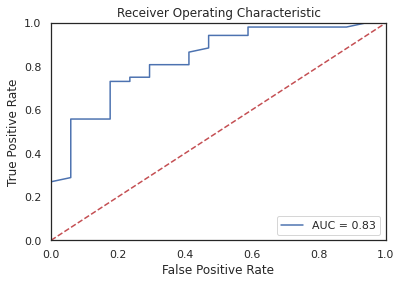

In [123]:
from sklearn.metrics import roc_curve, auc

class_probabilities = clf_xgb.predict_proba(X_test)
preds = class_probabilities[:, 1]

fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

print(f"AUC for our classifier is: {roc_auc}")

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


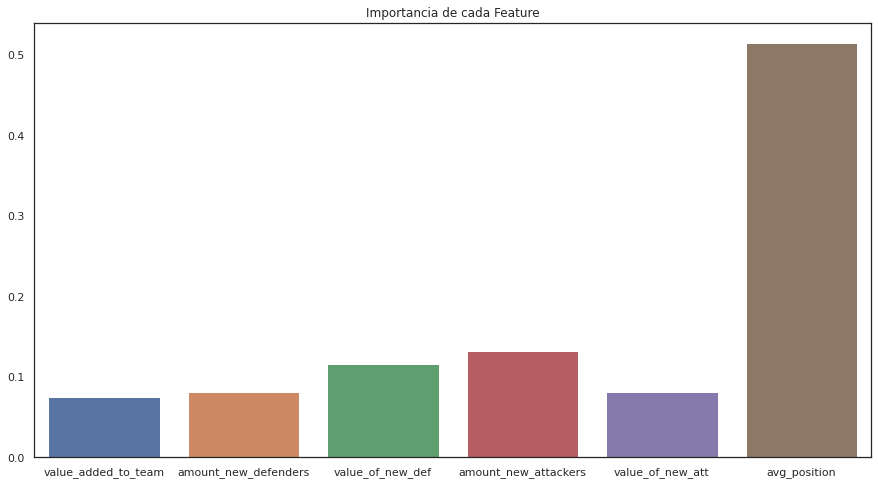

In [124]:
plt.figure(figsize=(15,8))
importances = clf_xgb.feature_importances_
columns = X.columns
sns.barplot(columns, importances)
plt.title('Importancia de cada Feature')
plt.show()